# Abstractive Text Summarisation using Transformers: Data Preparation and Fine Tuning of BART model

Text summarisation is a Natural Language Processing technique, that consist in the creation of automatic summaries from a text. Its applications are multiple, from the Media and News industry to the Financial Markets. In this project, we are going to analyse the application in the Legal Domain, a sector characterised by a lot of textual data, where automatic summarisation can without doubt bring a lot of value and efficiency.

In this project, we are going to explore the process of fine-tuning a transformer model, in order to produce abstractive summaries of legal documents. To do so, we are going to use fastai and blurr libraries, plus the dataset "BillSum". Finally, the model selected for this task is called BART, which stands for Bidirectional Auto-Regressive Transformer. This model was introduced by Facebook in 2019. For more information about the model, this is the link to the original paper:

https://arxiv.org/abs/1910.13461

The approach used is the following. First, the data is loaded and cleaned. Then, 3 different training scenarios are presented, according to the various parts of the model which are unfrozen or kept frozen. In addition, for each scenario, two values for the batch size are used. Finally, for each scenario, the results of the model are evaluated using the ROUGE score.

The code for this project is take from the following tutorial:

https://github.com/ohmeow/ohmeow_website/blob/master/_notebooks/2020-05-23-text-generation-with-blurr.ipynb


# Install and import libraries

In [ ]:
!pip install ohmeow-blurr -q

     |████████████████████████████████| 61kB 5.7MB/s 
     |████████████████████████████████| 1.2MB 16.0MB/s 
     |████████████████████████████████| 4.1MB 36.0MB/s 
     |████████████████████████████████| 1.8MB 40.5MB/s 
     |████████████████████████████████| 163kB 44.3MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 194kB 37.4MB/s 
     |████████████████████████████████| 14.5MB 220kB/s 
     |████████████████████████████████| 890kB 35.7MB/s 
     |████████████████████████████████| 2.9MB 38.8MB/s 
     |████████████████████████████████| 245kB 43.3MB/s 
     |████████████████████████████████| 20.7MB 45.3MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 


In [ ]:
!pip install datasets -q

In [ ]:
!pip install bert_score

     |████████████████████████████████| 61kB 5.8MB/s 


In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge 

In [ ]:
import datasets
import pandas as pd
from fastai.text.all import *
from transformers import *

from blurr.data.all import *
from blurr.modeling.all import *

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Load data and data cleaning

## Data loading

In [ ]:
raw_data = datasets.load_dataset('billsum', '3.0.0', split='train[:100%]') #load full dataset from the dataset library

Using custom data configuration 3.0.0


Dataset billsum downloaded and prepared to /root/.cache/huggingface/datasets/billsum/3.0.0/3.0.0/dfbb38fcc96577d054cdcb8accc369486d1a2281a6a2ce938ad7f0b652f3416e. Subsequent calls will reuse this data.


The Billsum dataset contains thousands of US Congressional and California state bills. The features of the dataset are:

  * summary: summary of the bill
  * text: full text of the bill
  * title: title of the bill

In [ ]:
df = pd.DataFrame(raw_data) #import the dataset into a pd dataframe

In [ ]:
df.shape #number of rows and columns

(18949, 3)

In [ ]:
df.head(2)

,summary,text,title
0,Shields a business entity from civil liability relating to any injury or death occurring at a facility of that entity in connection with a use of such facility by a nonprofit organization if: (1) the use occurs outside the scope of business of the business entity; (2) such injury or death occurs during a period that such facility is used by such organization; and (3) the business entity authorized the use of such facility by the organization. \nMakes this Act inapplicable to an injury or death that results from an act or omission of a business entity that constitutes gross negligence or in...,"SECTION 1. LIABILITY OF BUSINESS ENTITIES PROVIDING USE OF FACILITIES \n TO NONPROFIT ORGANIZATIONS.\n\n (a) Definitions.--In this section:\n (1) Business entity.--The term ``business entity'' means a \n firm, corporation, association, partnership, consortium, joint \n venture, or other form of enterprise.\n (2) Facility.--The term ``facility'' means any real \n property, including any building, improvement, or appurtenance.\n (3) Gross negligence.--The term ``gross negligence'' means \n voluntary and conscious co...",A bill to limit the civil liability of business entities providing use of facilities to nonprofit organizations.
1,"Human Rights Information Act - Requires certain Federal agencies to identify and organize all human rights records regarding activities occurring in Guatemala and Honduras after 1944 for declassification and disclosure purposes, and to make them available to the public. \nInstructs the President to report to Congress regarding agency compliance. \nPrescribes guidelines under which the Interagency Security Classification Appeals Panel shall review agency determinations to postpone public disclosure of any human rights record. Authorizes postponement of such public disclosures on specified ...","SECTION 1. SHORT TITLE.\n\n This Act may be cited as the ``Human Rights Information Act''.\n\nSEC. 2. FINDINGS.\n\n Congress finds the following:\n (1) The people of the United States consider the national \n and international protection and promotion of human rights and \n the rule of law the most important values of any democracy. The \n founding fathers defined human rights prominently in the Bill \n of Rights, giving those rights a special priority and \n protection in the Constitution.\n (2) Federal agencies are in possess...",Human Rights Information Act


In [ ]:
#convert fields to string type
df['summary'] = df['summary'].astype('string')
df['text'] = df['text'].astype('string')
df['title'] = df['title'].astype('string')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18949 entries, 0 to 18948
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   summary  18949 non-null  string
 1   text     18949 non-null  string
 2   title    18949 non-null  string
dtypes: string(3)
memory usage: 444.2 KB


## Data cleaning

In this section, we are going to clean our text data as much as possible, for example removing the special characters and quotations, in order for our model to focus only on the text part.

In [ ]:
df.head(2)

,summary,text,title
0,Shields a business entity from civil liability relating to any injury or death occurring at a facility of that entity in connection with a use of such facility by a nonprofit organization if: (1) the use occurs outside the scope of business of the business entity; (2) such injury or death occurs during a period that such facility is used by such organization; and (3) the business entity authorized the use of such facility by the organization. Makes this Act inapplicable to an injury or death that results from an act or omission of a business entity that constitutes gross negligence or int...,"SECTION 1. LIABILITY OF BUSINESS ENTITIES PROVIDING USE OF FACILITIES TO NONPROFIT ORGANIZATIONS. (a) Definitions.--In this section: (1) Business entity.--The term ``business entity'' means a firm, corporation, association, partnership, consortium, joint venture, or other form of enterprise. (2) Facility.--The term ``facility'' means any real property, including any building, improvement, or appurtenance. (3) Gross negligence.--The term ``gross negligence'' means voluntary and conscious conduct by a...",A bill to limit the civil liability of business entities providing use of facilities to nonprofit organizations.
1,"Human Rights Information Act - Requires certain Federal agencies to identify and organize all human rights records regarding activities occurring in Guatemala and Honduras after 1944 for declassification and disclosure purposes, and to make them available to the public. Instructs the President to report to Congress regarding agency compliance. Prescribes guidelines under which the Interagency Security Classification Appeals Panel shall review agency determinations to postpone public disclosure of any human rights record. Authorizes postponement of such public disclosures on specified gr...","SECTION 1. SHORT TITLE. This Act may be cited as the ``Human Rights Information Act''. SEC. 2. FINDINGS. Congress finds the following: (1) The people of the United States consider the national and international protection and promotion of human rights and the rule of law the most important values of any democracy. The founding fathers defined human rights prominently in the Bill of Rights, giving those rights a special priority and protection in the Constitution. (2) Federal agencies are in possession of docume...",Human Rights Information Act


Clean 'text' column

In [ ]:
df['text'] = df['text'].str.replace(r"'","", regex=True) #remove ' from text
df['text'] = df['text'].str.replace(r"`","", regex=True) #remove ` from text
df['text'] = df['text'].str.replace(r"-","", regex=True) #remove - from text
df['text'] = df['text'].str.replace(r'"','', regex=True) #remove " from text
df['text'] = df['text'].str.replace(r"\(.{1,5}\)","", regex=True) #remove all expressions of 1 to 5 letter or number between parenthesis from text
df['text'] = df['text'].str.replace(r'\n','', regex=True) #remove \n from text

Clean 'summary' column

In [ ]:
df['summary'] = df['summary'].str.replace(r"'","", regex=True) #remove ' from summary
df['summary'] = df['summary'].str.replace(r"`","", regex=True) #remove ` from summary
df['summary'] = df['summary'].str.replace(r"-","", regex=True) #remove - from summary
df['summary'] = df['summary'].str.replace(r'"','', regex=True) #remove " from summary
df['summary'] = df['summary'].str.replace(r"\(.{1,5}\)","", regex=True) #remove all expressions of 1 to 5 letter or number between parenthesis from summary
df['summary'] = df['summary'].str.replace(r'\n','', regex=True) #remove \n from summary

In [ ]:
df.head(2)

,summary,text,title
0,Shields a business entity from civil liability relating to any injury or death occurring at a facility of that entity in connection with a use of such facility by a nonprofit organization if: the use occurs outside the scope of business of the business entity; such injury or death occurs during a period that such facility is used by such organization; and the business entity authorized the use of such facility by the organization. Makes this Act inapplicable to an injury or death that results from an act or omission of a business entity that constitutes gross negligence or intentional m...,"SECTION 1. LIABILITY OF BUSINESS ENTITIES PROVIDING USE OF FACILITIES TO NONPROFIT ORGANIZATIONS. Definitions.In this section: Business entity.The term business entity means a firm, corporation, association, partnership, consortium, joint venture, or other form of enterprise. Facility.The term facility means any real property, including any building, improvement, or appurtenance. Gross negligence.The term gross negligence means voluntary and conscious conduct by a person with knowledge (at the tim...",A bill to limit the civil liability of business entities providing use of facilities to nonprofit organizations.
1,"Human Rights Information Act Requires certain Federal agencies to identify and organize all human rights records regarding activities occurring in Guatemala and Honduras after 1944 for declassification and disclosure purposes, and to make them available to the public. Instructs the President to report to Congress regarding agency compliance. Prescribes guidelines under which the Interagency Security Classification Appeals Panel shall review agency determinations to postpone public disclosure of any human rights record. Authorizes postponement of such public disclosures on specified groun...","SECTION 1. SHORT TITLE. This Act may be cited as the Human Rights Information Act.SEC. 2. FINDINGS. Congress finds the following: The people of the United States consider the national and international protection and promotion of human rights and the rule of law the most important values of any democracy. The founding fathers defined human rights prominently in the Bill of Rights, giving those rights a special priority and protection in the Constitution. Federal agencies are in possession of documents pertaining ...",Human Rights Information Act


In [ ]:
count = df['text'].str.split().apply(len) #create a series with the count of the number of words for each text

We are going to take a subset of the dataframe to train, validate and test our model. For GPU limitations, we are going to take only text laws with maximum number of words = 1000.

In [ ]:
df_mod = df.loc[count < 1000] #create a dataframe for training purposes

In [ ]:
df_mod.shape

(7810, 3)

In [ ]:
df_mod.head(2)

,summary,text,title
0,Shields a business entity from civil liability relating to any injury or death occurring at a facility of that entity in connection with a use of such facility by a nonprofit organization if: the use occurs outside the scope of business of the business entity; such injury or death occurs during a period that such facility is used by such organization; and the business entity authorized the use of such facility by the organization. Makes this Act inapplicable to an injury or death that results from an act or omission of a business entity that constitutes gross negligence or intentional m...,"SECTION 1. LIABILITY OF BUSINESS ENTITIES PROVIDING USE OF FACILITIES TO NONPROFIT ORGANIZATIONS. Definitions.In this section: Business entity.The term business entity means a firm, corporation, association, partnership, consortium, joint venture, or other form of enterprise. Facility.The term facility means any real property, including any building, improvement, or appurtenance. Gross negligence.The term gross negligence means voluntary and conscious conduct by a person with knowledge (at the tim...",A bill to limit the civil liability of business entities providing use of facilities to nonprofit organizations.
8,"Marine Debris Act Reauthorization Amendments of 2012 Reauthorizes appropriations through FY2015 for, and revises provisions of, the Marine Debris Research, Prevention, and Reduction Act.(Sec. 3) Renames such Act as the Marine Debris Act. Replaces provisions establishing within the National Oceanic and Atmospheric Administration the Marine Debris Prevention and Removal Program with provisions establishing the Marine Debris Program to identify, determine sources of, assess, prevent, reduce, and remove the occurrence and adverse impacts of marine debris on the U.S. economy, the marine envir...","SECTION 1. SHORT TITLE. This Act may be cited as the Marine Debris Act Amendments of 2012.SEC. 2. REFERENCES. Except as otherwise expressly provided, whenever in this Act an amendment is expressed as an amendment to a section or other provision, the reference shall be considered to be made to a section or other provision of the Marine Debris Research, Prevention, and Reduction Act (33 U.S.C. 1951 et seq.), as in effect immediately before the enactment of this Act.SEC. 3. SHORT TITLE AMENDMENT. Section 1 (33 U.S.C. 1951 note) is amended by striking Research, Prevention, and Reducti...","To reauthorize and amend the Marine Debris Research, Prevention, and Reduction Act."


In this part we are going to break each word by itself, and then put them back together, in order to eliminate tabulations.

In [ ]:
results = []
for i in range(0,len(df_mod)):
  text = df_mod.iloc[i,1]
  a_text = text.split()
  new_text = " ".join(a_text)
  results.append(new_text)

In [ ]:
df_mod['new_text'] = results #add the text to the df_mod dataframe

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_mod.head(2)

,summary,text,title,new_text
0,Shields a business entity from civil liability relating to any injury or death occurring at a facility of that entity in connection with a use of such facility by a nonprofit organization if: the use occurs outside the scope of business of the business entity; such injury or death occurs during a period that such facility is used by such organization; and the business entity authorized the use of such facility by the organization. Makes this Act inapplicable to an injury or death that results from an act or omission of a business entity that constitutes gross negligence or intentional m...,"SECTION 1. LIABILITY OF BUSINESS ENTITIES PROVIDING USE OF FACILITIES TO NONPROFIT ORGANIZATIONS. Definitions.In this section: Business entity.The term business entity means a firm, corporation, association, partnership, consortium, joint venture, or other form of enterprise. Facility.The term facility means any real property, including any building, improvement, or appurtenance. Gross negligence.The term gross negligence means voluntary and conscious conduct by a person with knowledge (at the tim...",A bill to limit the civil liability of business entities providing use of facilities to nonprofit organizations.,"SECTION 1. LIABILITY OF BUSINESS ENTITIES PROVIDING USE OF FACILITIES TO NONPROFIT ORGANIZATIONS. Definitions.In this section: Business entity.The term business entity means a firm, corporation, association, partnership, consortium, joint venture, or other form of enterprise. Facility.The term facility means any real property, including any building, improvement, or appurtenance. Gross negligence.The term gross negligence means voluntary and conscious conduct by a person with knowledge (at the time of the conduct) that the conduct is likely to be harmful to the health or wellbeing of anoth..."
8,"Marine Debris Act Reauthorization Amendments of 2012 Reauthorizes appropriations through FY2015 for, and revises provisions of, the Marine Debris Research, Prevention, and Reduction Act.(Sec. 3) Renames such Act as the Marine Debris Act. Replaces provisions establishing within the National Oceanic and Atmospheric Administration the Marine Debris Prevention and Removal Program with provisions establishing the Marine Debris Program to identify, determine sources of, assess, prevent, reduce, and remove the occurrence and adverse impacts of marine debris on the U.S. economy, the marine envir...","SECTION 1. SHORT TITLE. This Act may be cited as the Marine Debris Act Amendments of 2012.SEC. 2. REFERENCES. Except as otherwise expressly provided, whenever in this Act an amendment is expressed as an amendment to a section or other provision, the reference shall be considered to be made to a section or other provision of the Marine Debris Research, Prevention, and Reduction Act (33 U.S.C. 1951 et seq.), as in effect immediately before the enactment of this Act.SEC. 3. SHORT TITLE AMENDMENT. Section 1 (33 U.S.C. 1951 note) is amended by striking Research, Prevention, and Reducti...","To reauthorize and amend the Marine Debris Research, Prevention, and Reduction Act.","SECTION 1. SHORT TITLE. This Act may be cited as the Marine Debris Act Amendments of 2012.SEC. 2. REFERENCES. Except as otherwise expressly provided, whenever in this Act an amendment is expressed as an amendment to a section or other provision, the reference shall be considered to be made to a section or other provision of the Marine Debris Research, Prevention, and Reduction Act (33 U.S.C. 1951 et seq.), as in effect immediately before the enactment of this Act.SEC. 3. SHORT TITLE AMENDMENT. Section 1 (33 U.S.C. 1951 note) is amended by striking Research, Prevention, and Reduction.SEC. 4..."


Then we are creating a dataframe only with the variables that we need, which are the cleaned text of the bills and they respecrive summaries.

In [ ]:
df_fin = df_mod[['summary', 'new_text']] #create the final dataframe with only the data needed for the training

In [ ]:
df_fin.head(2)

,summary,new_text
0,Shields a business entity from civil liability relating to any injury or death occurring at a facility of that entity in connection with a use of such facility by a nonprofit organization if: the use occurs outside the scope of business of the business entity; such injury or death occurs during a period that such facility is used by such organization; and the business entity authorized the use of such facility by the organization. Makes this Act inapplicable to an injury or death that results from an act or omission of a business entity that constitutes gross negligence or intentional m...,"SECTION 1. LIABILITY OF BUSINESS ENTITIES PROVIDING USE OF FACILITIES TO NONPROFIT ORGANIZATIONS. Definitions.In this section: Business entity.The term business entity means a firm, corporation, association, partnership, consortium, joint venture, or other form of enterprise. Facility.The term facility means any real property, including any building, improvement, or appurtenance. Gross negligence.The term gross negligence means voluntary and conscious conduct by a person with knowledge (at the time of the conduct) that the conduct is likely to be harmful to the health or wellbeing of anoth..."
8,"Marine Debris Act Reauthorization Amendments of 2012 Reauthorizes appropriations through FY2015 for, and revises provisions of, the Marine Debris Research, Prevention, and Reduction Act.(Sec. 3) Renames such Act as the Marine Debris Act. Replaces provisions establishing within the National Oceanic and Atmospheric Administration the Marine Debris Prevention and Removal Program with provisions establishing the Marine Debris Program to identify, determine sources of, assess, prevent, reduce, and remove the occurrence and adverse impacts of marine debris on the U.S. economy, the marine envir...","SECTION 1. SHORT TITLE. This Act may be cited as the Marine Debris Act Amendments of 2012.SEC. 2. REFERENCES. Except as otherwise expressly provided, whenever in this Act an amendment is expressed as an amendment to a section or other provision, the reference shall be considered to be made to a section or other provision of the Marine Debris Research, Prevention, and Reduction Act (33 U.S.C. 1951 et seq.), as in effect immediately before the enactment of this Act.SEC. 3. SHORT TITLE AMENDMENT. Section 1 (33 U.S.C. 1951 note) is amended by striking Research, Prevention, and Reduction.SEC. 4..."


Here we are going to split our dataframe in train and test, leaving 20% of the data for testing.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df_train, df_test = train_test_split(df_fin, test_size=0.2, random_state=42)

In [ ]:
df_fin.shape

(7810, 2)

In [ ]:
df_train.shape

(6248, 2)

In [ ]:
df_test.shape

(1562, 2)

# Modelling, Training and Evaluation



## Scenario 1: Only Decoder Unfreezed Trained with 10 epochs

### Scenario 1.1: Batch Size = 2

#### Modelling

Here we are creating the architecture, model, tokenizer and configuration. Bewteen the different typologies of BART model, we are going to use the "smaller" one, called "bart-base", because of GPU limitations related to Google Colab.

In [ ]:
pretrained_model_name = "facebook/bart-base" 
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In this part, we are preparing the input data that we will use to feed the model. More specifically, we are defining some parameters such as the maximum input length of the text and of the summaries and the batch size.

In [ ]:
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='summarization'); text_gen_kwargs

{'bad_words_ids': None,
 'bos_token_id': 0,
 'decoder_start_token_id': 2,
 'diversity_penalty': 0.0,
 'do_sample': False,
 'early_stopping': True,
 'eos_token_id': 2,
 'length_penalty': 1.0,
 'max_length': 128,
 'min_length': 12,
 'no_repeat_ngram_size': 3,
 'num_beam_groups': 1,
 'num_beams': 4,
 'num_return_sequences': 1,
 'output_attentions': False,
 'output_hidden_states': False,
 'output_scores': False,
 'pad_token_id': 1,
 'repetition_penalty': 1.0,
 'return_dict_in_generate': False,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'use_cache': True}

In [ ]:
hf_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, 
                                              max_length=1000, max_tgt_length=300, text_gen_kwargs=text_gen_kwargs)

blocks = (HF_Seq2SeqBlock(before_batch_tfm=hf_batch_tfm), noop)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('new_text'), #variable containing the full text of the law
                   get_y=ColReader('summary'), #variable containing the summary text of the law
                   splitter=RandomSplitter()) #this function performs a train/validation split of the input data, with 0.2 for validation

Here we are creating the dataloader, taking the training dataframe as input and defining 2 as batch size.

In [ ]:
dls = dblock.dataloaders(df_train, bs=2) #batch size = 2

Here we can see the input data splitted between training and validation.

In [ ]:
len(dls.train.items), len(dls.valid.items)

(4999, 1249)

#### Training

In this section the training of the model is performed. First of all, we are defining the Learner, which takes as input the dataloader and the model previously defined, as well as the optimisation and loss functions. Very interesting is the "seq2seq_splitter" function, which defines the splitting of the model in different parameters groups, in order to be able to freeze and unfreeze the different layers of the model. In the case of BART model, these parameters groups are: Embeddings, Model-Encoder and Model-Decoder. In this scenario, we are going to leave only the parameter group related to the decoder unfrozen, so only the wights related to the decoder will be left trainable.

In [ ]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]

learn = Learner(dls, #input data
                model, #bart model
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16() #splitter function defines how the model is splitted in order to control the freeze/defreeze of the layers

learn.create_opt() #create an optimizer with default hyper-parameters
learn.freeze() #leave only the decoder layers unfrozen

In [ ]:
print(model) #to see the architecture of the model

With the "lr_find" function, we are going to make a mock training to have a simulation of the effect of different learning rates on the loss of the model, in order to find the optimal learnign rate to be used in the training. A rule to choose the optimal maximum learning rate is to take a learning rate before the minimum, where the loss still improves.

Source: https://fastai1.fast.ai/callbacks.one_cycle.html

SuggestedLRs(lr_min=0.2290867567062378, lr_steep=1.9054607152938843)

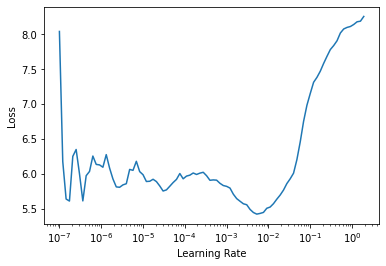

In [ ]:
learn.lr_find(suggestions=True)

We are going to train the network using the One-Cycle Policy. It consist of training the model using a cycle of two equal lenght, one going from a lower training rate to an higher one and then going from this max learning rate (defined by the user in the previous step) to a lower rate again. The lower rate can be ten times lower. The lower learning rates at the beginning are used to warm-up the training, while the higher rates at the medium of the cycle have a regularisation effect, that prevents the model from overfitting. Finally, with rates decreasing again allows the model to find a local minimum. This policy proved to provide a more efficient training, reaching high performances with much less epochs than a traditional training.

Source: https://sgugger.github.io/the-1cycle-policy.html

In [ ]:
learn.fit_one_cycle(5, lr_max=3e-4) #train with 5 epochs and learning rate suggested

epoch,train_loss,valid_loss,time
0,2.340254,2.123901,10:51
1,1.754654,1.576141,10:52
2,1.248456,1.276465,10:52
3,1.016012,1.162819,10:52
4,0.817145,1.156850,10:49


SuggestedLRs(lr_min=1.2022644114040304e-06, lr_steep=1.0964781722577754e-06)

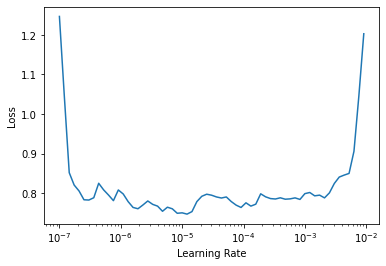

In [ ]:
learn.lr_find(suggestions=True) #run again the lr_find function after the first 5 epochs to adjust the learning rate

In [ ]:
learn.fit_one_cycle(5, lr_max=3e-7) #train with 5 additional epochs and learning rate suggested

epoch,train_loss,valid_loss,time
0,0.867753,1.158100,10:53
1,0.805881,1.159900,10:47
2,0.844391,1.160386,10:49
3,0.877405,1.160664,10:46
4,0.865067,1.160733,10:48


In [ ]:
str(learn.blurr_generate(df_test.iloc[0,1], min_length = 100, max_length = 300)) #example of generated text

"[' Drill Now Act of 2008  Amends the Department of the Interior, Environment, and Related Agencies Appropriations Act, 2008 to authorize the Secretary of Defense to conduct leasing, preleasing, and related activities for any opened area before June 30, 2012, notwithstanding the omission of the opened area from the Outer Continental Shelf leasing program developed pursuant to this Act.  Requires the Secretary to deposit rentals, royalties, bonus bids, and other sums due and payable from any leased tract within an opened area, and from all other leased tracts in any other area for which leases are entered into after enactment of this Act, as follows:  50 percent in the general fund of the Treasury; and  50 in a special account in the Treasury, for allocation among the states.  Prohibits the Secretary from receiving any amount from a leased tract if the geographical center of that leased tract is more than 200 nautical miles from the coastline of that state.  Provides that amounts made a

In [ ]:
learn.export(fname='export_1_1.pkl') #export the model to a file, in order to use it afterwards for inference

#### Evaluation

In this part, we are going to evaluate the model produced using the test set we created before. This set is composed of about 1500 data points.

In [ ]:
df_test_1_1 = df_test.copy()

In [ ]:
n_rows = df_test_1_1.shape[0]

In [ ]:
n_rows

1562

In this code, we are automatically generating the summaries for all the texts present in the test set, storing them in a list and merging the results to the test set itself.

In [ ]:
%%time
results_test = []
for i in range(0,n_rows):
  pred = learn.blurr_generate(df_test_1_1.iloc[i,1], min_length = 100, max_length = 300)
  results_test.append(str(pred))

CPU times: user 45min 44s, sys: 4min 34s, total: 50min 18s
Wall time: 50min 18s


In [ ]:
df_test_1_1['pred'] = results_test

In [ ]:
df_test_1_1.head(2)

,summary,new_text,pred
14118,"Drill Now Act of 2008 Amends the Department of the Interior, Environment, and Related Agencies Appropriations Act, 2008 to repeal its prohibitions against oil and natural gas preleasing and leasing activities in specified offshore areas, including the North Atlantic, the eastern Gulf of Mexico, and the MidAtlantic and South Atlantic planning areas.Declares that the United States reserves the right to designate national defense areas on the outer Continental Shelf .Authorizes the Secretary of the Interior (Secretary) to conduct leasing, preleasing, and related activities for any opened are...","SECTION 1. SHORT TITLE. This Act may be cited as the Drill Now Act of 2008.SEC. 2. DEFINITIONS. In this Act: Opened area.The term opened area means any area of the outer Continental shelf that before the date of enactment of this Act, was closed to oil or gas leasing; and as of the date of enactment of this Act, is made available for leasing pursuant to section 3 and the amendments made by that section. Secretary.The term Secretary means the Secretary of the Interior.SEC. 3. LEASING ON OUTER CONTINENTAL SHELF. Opening New Offshore Areas to Oil and Gas Development. In general.Sections 104 a...","[' Drill Now Act of 2008 Amends the Department of the Interior, Environment, and Related Agencies Appropriations Act, 2008 to authorize the Secretary of Defense to conduct leasing, preleasing, and related activities for any opened area before June 30, 2012, notwithstanding the omission of the opened area from the Outer Continental Shelf leasing program developed pursuant to this Act. Requires the Secretary to deposit rentals, royalties, bonus bids, and other sums due and payable from any leased tract within an opened area, and from all other leased tracts in any other area for which leas..."
17891,"Virgin Islands Visa Waiver Act of 2012 Amends the Immigration and Nationality Act to establish a visa waiver program for the United States Virgin Islands for a national of a country that is a member or an associate member of the Caribbean Community (CARICOM) listed in regulations under this Act and who is applying for admission as a nonimmigrant business or pleasure visitor solely for entry into and stay in the United States Virgin Islands for not more than 30 days, if the Secretary of Homeland Security determines that such waiver does not represent a threat to the welfare or security of...","SECTION 1. SHORT TITLE. This Act may be cited as the Virgin Islands Visa Waiver Act of 2012.SEC. 2. VIRGIN ISLANDS VISA WAIVER PROGRAM. In General.Section 212 of the Immigration and Nationality Act (8 U.S.C. 1182 is amended by amending the subsection heading to read as follows: Guam, Northern Mariana Islands, and Virgin Islands Visa Waiver Programs.; and by adding at the end the following: Virgin islands visa waiver program. In general.The requirement of subsection may be waived by the Secretary of Homeland Security, in the case of an alien who is a national of a country described in subpa...","[' Virgin Islands Visa Waiver Act of 2012 Amends the Immigration and Nationality Act to authorize the Secretary of Homeland Security, in the case of an alien who is a national of a country that is a member or an associate member of the Caribbean Community (CARICOM) and who is applying for admission as a nonimmigrant visitor for business or pleasure and solely for entry into and stay in the United States Virgin Islands for a period not to exceed 30 days, if the Secretary determines that such waiver does not represent a threat to U.S. welfare, safety, or security.']"


In this section, we are going to introduce and calculate the Rouge Metric, which is a specific NLP metric used to evaluate the results of text summarisation. This metric is evaluating the similarity between the human generated summaries and the machine generated ones, in terms of number of words they have in common. We chose 3 types of Rouge scores:

  * Rouge-1: takes into consideration for the calculation the number of individual words the two summaries have in common;
  * Rouge-2: takes into consideration for the calculation the number of bi-grams the two summaries have in common;
  * Rouge-L: takes into consideration for the calculation the longest common subsequences between the two summaries.

For each of these 3 scores we calculated the precision, recall and the F score. We decided to take the F score because it is a good balance between precision and recall.

Recall: Number of overlapping words between the two summaries divided by the number of words in the human generated summary

Precision: Recall: Number of overlapping words between the two summaries divided by the number of words in the model generated summary

F score: Combination of precision and recall

Source: https://www.freecodecamp.org/news/what-is-rouge-and-how-it-works-for-evaluation-of-summaries-e059fb8ac840/#:~:text=ROUGE%20stands%20for%20Recall%2DOriented,as%20well%20as%20machine%20translations.&text=If%20we%20consider%20just%20the,and%20reference%20summary%20is%206.

In [ ]:
rouge = Rouge()

Here we are calculating the scores for each pair of summaries (machine and human generated) in the test set and store the results in a list.

In [ ]:
results_rouge = []
for i in range(0,n_rows):
  scores = rouge.get_scores(df_test_1_1['pred'].iloc[i], df_test_1_1['summary'].iloc[i])
  results_rouge.append(scores)

In [ ]:
results_rouge

[[{'rouge-1': {'f': 0.5304136203077179, 'p': 0.5165876777251185, 'r': 0.545},
   'rouge-2': {'f': 0.30806845466131844, 'p': 0.3, 'r': 0.3165829145728643},
   'rouge-l': {'f': 0.4251968453949408, 'p': 0.432, 'r': 0.4186046511627907}}],
 [{'rouge-1': {'f': 0.5659163943056834,
    'p': 0.8627450980392157,
    'r': 0.42105263157894735},
   'rouge-2': {'f': 0.4595469211658864,
    'p': 0.7029702970297029,
    'r': 0.34134615384615385},
   'rouge-l': {'f': 0.6046511580611141,
    'p': 0.7878787878787878,
    'r': 0.49056603773584906}}],
 [{'rouge-1': {'f': 0.3707317031367044,
    'p': 0.2638888888888889,
    'r': 0.6229508196721312},
   'rouge-2': {'f': 0.24630541455507296,
    'p': 0.17482517482517482,
    'r': 0.4166666666666667},
   'rouge-l': {'f': 0.3687943217966904,
    'p': 0.2765957446808511,
    'r': 0.5531914893617021}}],
 [{'rouge-1': {'f': 0.6199999950125001,
    'p': 0.6526315789473685,
    'r': 0.5904761904761905},
   'rouge-2': {'f': 0.4040403990531579,
    'p': 0.425531914893

Here we are extracting the results of each rouge metric from the previous dictionary and storing them in other lists.

In [ ]:
result_rouge_1 = []
result_rouge_2 = []
result_rouge_L = []
for i in range(0,100):
  dict_var = results_rouge[i][0] #extract the dictionary containing the rouge values
  rouge_1 = dict_var['rouge-1']['f'] #store the f value of the rouge-1 metric
  rouge_2 = dict_var['rouge-2']['f'] #store the f value of the rouge-1 metric
  rouge_L = dict_var['rouge-l']['f'] #store the f value of the rouge-1 metric
  result_rouge_1.append(rouge_1) #store the value in the list
  result_rouge_2.append(rouge_2) #store the value in the list
  result_rouge_L.append(rouge_L) #store the value in the list

Finally, here we are calculating the average for each one of the 3 metrics selected.

In [ ]:
import numpy as np

In [ ]:
np.mean(result_rouge_1)

0.4865734301036179

In [ ]:
np.mean(result_rouge_2)

0.3003350982422885

In [ ]:
np.mean(result_rouge_L)

0.45698558160839153

### Scenario 1.2: Batch Size = 4

#### Modelling

Here we are creating the architecture, model, tokenizer and configuration. Bewteen the different typologies of BART model, we are going to use the "smaller" one, called "bart-base", because of GPU limitations related to Google Colab.

In [ ]:
pretrained_model_name = "facebook/bart-base"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In this part, we are preparing the input data that we will use to feed the model. More specifically, we are defining some parameters such as the maximum input length of the text and of the summaries and the batch size.

In [ ]:
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='summarization'); text_gen_kwargs

{'bad_words_ids': None,
 'bos_token_id': 0,
 'decoder_start_token_id': 2,
 'diversity_penalty': 0.0,
 'do_sample': False,
 'early_stopping': True,
 'eos_token_id': 2,
 'length_penalty': 1.0,
 'max_length': 128,
 'min_length': 12,
 'no_repeat_ngram_size': 3,
 'num_beam_groups': 1,
 'num_beams': 4,
 'num_return_sequences': 1,
 'output_attentions': False,
 'output_hidden_states': False,
 'output_scores': False,
 'pad_token_id': 1,
 'repetition_penalty': 1.0,
 'return_dict_in_generate': False,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'use_cache': True}

In [ ]:
hf_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, 
                                              max_length=1000, max_tgt_length=300, text_gen_kwargs=text_gen_kwargs)

blocks = (HF_Seq2SeqBlock(before_batch_tfm=hf_batch_tfm), noop)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('new_text'), #variable containing the full text of the law
                   get_y=ColReader('summary'), #variable containing the summary text of the law
                   splitter=RandomSplitter()) #this function performs a train/validation split of the input data, with 0.2 for validation

Here we are creating the dataloader, taking the training dataframe as input and defining 4 as batch size.

In [ ]:
dls = dblock.dataloaders(df_train, bs=4) #batch size = 4

Here we can see the input data splitted between training and validation.

In [ ]:
len(dls.train.items), len(dls.valid.items)

(4999, 1249)

#### Training

In this section the training of the model is performed. First of all, we are defining the Learner, which takes as input the dataloader and the model previously defined, as well as the optimisation and loss functions. Very interesting is the "seq2seq_splitter" function, which defines the splitting of the model in different parameters groups, in order to be able to freeze and unfreeze the different layers of the model. In the case of BART model, these parameters groups are: Embeddings, Model-Encoder and Model-Decoder. In this scenario, we are going to leave only the parameter group related to the decoder unfrozen, so only the wights related to the decoder will be left trainable.

In [ ]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]

learn = Learner(dls, #input data
                model, #bart model
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.create_opt() #create an optimizer with default hyper-parameters
learn.freeze() #leave only the decoder layers unfrozen

In [ ]:
print(model)

With the "lr_find" function, we are going to make a mock training to have a simulation of the effect of different learning rates on the loss of the model, in order to find the optimal learnign rate to be used in the training. A rule to choose the optimal maximum learning rate is to take a learning rate before the minimum, where the loss still improves.

Source: https://fastai1.fast.ai/callbacks.one_cycle.html

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:54: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.13182567358016967, lr_steep=1.0964782238006592)

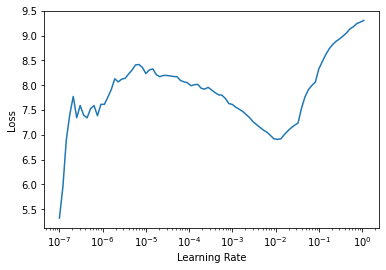

In [ ]:
learn.lr_find(suggestions=True)

We are going to train the network using the One-Cycle Policy. It consists of training the model using a cycle of two equal lenght, one going from a lower training rate to an higher one and then going from this max learning rate (defined by the user in the previous step) to a lower rate again. The lower rate can be ten times lower. The lower learning rates at the beginning are used to warm-up the training, while the higher rates at the medium of the cycle have a regularisation effect, that prevents the model from overfitting. Finally, with rates decreasing again allows the model to find a local minimum. This policy proved to provide a more efficient training, reaching high performances with much less epochs than traditional training.

Source: https://sgugger.github.io/the-1cycle-policy.html

In [ ]:
learn.fit_one_cycle(5, lr_max=3e-4) #train with 5 epochs and learning rate suggested

epoch,train_loss,valid_loss,time
0,2.832230,2.577182,09:02
1,2.123765,2.045899,09:01
2,1.656328,1.629519,09:02
3,1.327021,1.454244,09:03
4,1.264083,1.430873,09:04


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:54: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=1.9054607491852948e-06)

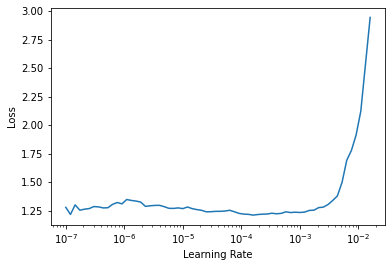

In [ ]:
learn.lr_find(suggestions=True) #run again the lr_find function after the first 5 epochs to adjust the learning rate

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-6) #train with 5 additional epochs and learning rate suggested

epoch,train_loss,valid_loss,time
0,1.247105,1.430603,09:01
1,1.247237,1.430176,09:01
2,1.219845,1.428954,09:01
3,1.241500,1.428202,09:01
4,1.187770,1.428072,09:01


In [ ]:
text = learn.blurr_generate(df_test.iloc[0,1], min_length = 100, max_length = 300) #example of generated text

[' Drill Now Act of 2008  Amends the Department of the Interior, Environment, and Related Agencies Appropriations Act, 2008 to authorize the Secretary of Defense to conduct leasing, preleasing, and related activities for any opened area before June 30, 2012, notwithstanding the omission of the opened area from the Outer Continental Shelf leasing program developed pursuant to this Act.  Sets forth provisions regarding:    deposit rentals, royalties, bonus bids, and other sums due and payable from any leased tract within an opened area, and from all other leased tracts in any other area for which leases are entered into after the date of enactment of this Act;  50 percent in the general fund of the Treasury; and  50 in a special account in the Treasury, for allocation by the Secretary among the States in accordance with such provisions.']

In [ ]:
str(text)

"[' Drill Now Act of 2008  Amends the Department of the Interior, Environment, and Related Agencies Appropriations Act, 2008 to authorize the Secretary of Defense to conduct leasing, preleasing, and related activities for any opened area before June 30, 2012, notwithstanding the omission of the opened area from the Outer Continental Shelf leasing program developed pursuant to this Act.  Sets forth provisions regarding:    deposit rentals, royalties, bonus bids, and other sums due and payable from any leased tract within an opened area, and from all other leased tracts in any other area for which leases are entered into after the date of enactment of this Act;  50 percent in the general fund of the Treasury; and  50 in a special account in the Treasury, for allocation by the Secretary among the States in accordance with such provisions.']"

In [ ]:
learn.export(fname='export_1_2.pkl') #export the model to a file, in order to use it afterwards for inference

#### Evaluation

In this part, we are going to evaluate the model produced using the test set we created before. This set is composed of about 1500 data points.

In [ ]:
df_test_1_2 = df_test.copy()

In [ ]:
n_rows = df_test_1_2.shape[0]

In [ ]:
n_rows

1562

In this code, we are automatically generating the summaries for all the texts present in the test set, storing them in a list and merging the results to the test set itself.

In [ ]:
%%time
results_test = []
for i in range(0,n_rows):
  pred = learn.blurr_generate(df_test_1_2.iloc[i,1], min_length = 100, max_length = 300)
  results_test.append(str(pred))

CPU times: user 42min 56s, sys: 4min 4s, total: 47min
Wall time: 47min


In [ ]:
df_test_1_2['pred'] = results_test

In [ ]:
df_test_1_2.head(2)

,summary,new_text,pred
14118,"Drill Now Act of 2008 Amends the Department of the Interior, Environment, and Related Agencies Appropriations Act, 2008 to repeal its prohibitions against oil and natural gas preleasing and leasing activities in specified offshore areas, including the North Atlantic, the eastern Gulf of Mexico, and the MidAtlantic and South Atlantic planning areas.Declares that the United States reserves the right to designate national defense areas on the outer Continental Shelf .Authorizes the Secretary of the Interior (Secretary) to conduct leasing, preleasing, and related activities for any opened are...","SECTION 1. SHORT TITLE. This Act may be cited as the Drill Now Act of 2008.SEC. 2. DEFINITIONS. In this Act: Opened area.The term opened area means any area of the outer Continental shelf that before the date of enactment of this Act, was closed to oil or gas leasing; and as of the date of enactment of this Act, is made available for leasing pursuant to section 3 and the amendments made by that section. Secretary.The term Secretary means the Secretary of the Interior.SEC. 3. LEASING ON OUTER CONTINENTAL SHELF. Opening New Offshore Areas to Oil and Gas Development. In general.Sections 104 a...","[' Drill Now Act of 2008 Amends the Department of the Interior, Environment, and Related Agencies Appropriations Act, 2008 to authorize the Secretary of Defense to conduct leasing, preleasing, and related activities for any opened area before June 30, 2012, notwithstanding the omission of the opened area from the Outer Continental Shelf leasing program developed pursuant to this Act. Sets forth provisions regarding: deposit rentals, royalties, bonus bids, and other sums due and payable from any leased tract within an opened area, and from all other leased tracts in any other area for ..."
17891,"Virgin Islands Visa Waiver Act of 2012 Amends the Immigration and Nationality Act to establish a visa waiver program for the United States Virgin Islands for a national of a country that is a member or an associate member of the Caribbean Community (CARICOM) listed in regulations under this Act and who is applying for admission as a nonimmigrant business or pleasure visitor solely for entry into and stay in the United States Virgin Islands for not more than 30 days, if the Secretary of Homeland Security determines that such waiver does not represent a threat to the welfare or security of...","SECTION 1. SHORT TITLE. This Act may be cited as the Virgin Islands Visa Waiver Act of 2012.SEC. 2. VIRGIN ISLANDS VISA WAIVER PROGRAM. In General.Section 212 of the Immigration and Nationality Act (8 U.S.C. 1182 is amended by amending the subsection heading to read as follows: Guam, Northern Mariana Islands, and Virgin Islands Visa Waiver Programs.; and by adding at the end the following: Virgin islands visa waiver program. In general.The requirement of subsection may be waived by the Secretary of Homeland Security, in the case of an alien who is a national of a country described in subpa...","[' Virgin Islands Visa Waiver Act of 2012 Amends the Immigration and Nationality Act to authorize the Secretary of Homeland Security, in the case of an alien who is a national of a country described in this Act and who is applying for admission as a nonimmigrant visitor for business or pleasure and solely for entry into and stay in the United States Virgin Islands for a period not to exceed 30 days, if the Secretary determines that such waiver does not represent a threat to U.S. welfare, safety, or security. Prohibits the Secretary from providing such a waiver unless: the alien has waive..."


In this section, we are going to introduce and calculate the Rouge Metric, which is a specific NLP metric used to evaluate the results of text summarisation. This metric is evaluating the similarity between the human generated summaries and the machine generated ones, in terms of number of words they have in common. We chose 3 types of Rouge scores:

  * Rouge-1: takes into consideration for the calculation the number of individual words the two summaries have in common;
  * Rouge-2: takes into consideration for the calculation the number of bi-grams the two summaries have in common;
  * Rouge-L: takes into consideration for the calculation the longest common subsequences between the two summaries.

For each of these 3 scores we calculated the precision, recall and the F score. We decided to take the F score because it is a good balance between precision and recall.

Recall: Number of overlapping words between the two summaries divided by the number of words in the human generated summary

Precision: Recall: Number of overlapping words between the two summaries divided by the number of words in the model generated summary

F score: Combination of precision and recall

Source: https://www.freecodecamp.org/news/what-is-rouge-and-how-it-works-for-evaluation-of-summaries-e059fb8ac840/#:~:text=ROUGE%20stands%20for%20Recall%2DOriented,as%20well%20as%20machine%20translations.&text=If%20we%20consider%20just%20the,and%20reference%20summary%20is%206.

In [ ]:
rouge = Rouge()

Here we are calculating the scores for each pair of summaries (machine and human generated) in the test set and store the results in a list.

In [ ]:
results_rouge = []
for i in range(0,n_rows):
  scores = rouge.get_scores(df_test_1_2['pred'].iloc[i], df_test_1_2['summary'].iloc[i])
  results_rouge.append(scores)

In [ ]:
results_rouge

[[{'rouge-1': {'f': 0.5325443738664614, 'p': 0.6521739130434783, 'r': 0.45},
   'rouge-2': {'f': 0.3392857094559595,
    'p': 0.41605839416058393,
    'r': 0.2864321608040201},
   'rouge-l': {'f': 0.43636363151280994,
    'p': 0.5274725274725275,
    'r': 0.37209302325581395}}],
 [{'rouge-1': {'f': 0.580808075823513,
    'p': 0.6149732620320856,
    'r': 0.5502392344497608},
   'rouge-2': {'f': 0.35025380212218815,
    'p': 0.3709677419354839,
    'r': 0.3317307692307692},
   'rouge-l': {'f': 0.4907407357424554, 'p': 0.4818181818181818, 'r': 0.5}}],
 [{'rouge-1': {'f': 0.3411764659868512,
    'p': 0.26605504587155965,
    'r': 0.47540983606557374},
   'rouge-2': {'f': 0.17857142397959197, 'p': 0.1388888888888889, 'r': 0.25},
   'rouge-l': {'f': 0.23809523341773756,
    'p': 0.189873417721519,
    'r': 0.3191489361702128}}],
 [{'rouge-1': {'f': 0.5140562200222578,
    'p': 0.4444444444444444,
    'r': 0.6095238095238096},
   'rouge-2': {'f': 0.33198380079267,
    'p': 0.2867132867132867

Here we are extracting the results of each rouge metric from the previous dictionary and storing them in other lists.

In [ ]:
result_rouge_1 = []
result_rouge_2 = []
result_rouge_L = []
for i in range(0,100):
  dict_var = results_rouge[i][0] #extract the dictionary containing the rouge values
  rouge_1 = dict_var['rouge-1']['f'] #store the f value of the rouge-1 metric
  rouge_2 = dict_var['rouge-2']['f'] #store the f value of the rouge-1 metric
  rouge_L = dict_var['rouge-l']['f'] #store the f value of the rouge-1 metric
  result_rouge_1.append(rouge_1) #store the value in the list
  result_rouge_2.append(rouge_2) #store the value in the list
  result_rouge_L.append(rouge_L) #store the value in the list

Finally, here we are calculating the average for each one of the 3 metrics selected.

In [ ]:
import numpy as np

In [ ]:
np.mean(result_rouge_1)

0.48572325432194785

In [ ]:
np.mean(result_rouge_2)

0.3014628350019139

In [ ]:
np.mean(result_rouge_L)

0.45110659898896627

## Scenario 2: Training 5 epochs with only Decoder Unfreezed and Retrain for other 5 epochs with both Decoder and Encoder Unfreezed

### Scenario 2.1: Batch Size = 2

#### Modelling

Here we are creating the architecture, model, tokenizer and configuration. Bewteen the different typologies of BART model, we are going to use the "smaller" one, called "bart-base", because of GPU limitations related to Google Colab.

In [ ]:
pretrained_model_name = "facebook/bart-base"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In this part, we are preparing the input data that we will use to feed the model. More specifically, we are defining some parameters such as the maximum input length of the text and of the summaries and the batch size.

In [ ]:
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='summarization'); text_gen_kwargs

{'bad_words_ids': None,
 'bos_token_id': 0,
 'decoder_start_token_id': 2,
 'diversity_penalty': 0.0,
 'do_sample': False,
 'early_stopping': True,
 'eos_token_id': 2,
 'length_penalty': 1.0,
 'max_length': 128,
 'min_length': 12,
 'no_repeat_ngram_size': 3,
 'num_beam_groups': 1,
 'num_beams': 4,
 'num_return_sequences': 1,
 'pad_token_id': 1,
 'repetition_penalty': 1.0,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'use_cache': True}

In [ ]:
hf_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, 
                                              max_length=1000, max_tgt_length=300, text_gen_kwargs=text_gen_kwargs)

blocks = (HF_Seq2SeqBlock(before_batch_tfm=hf_batch_tfm), noop)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('new_text'), #variable containing the full text of the law
                   get_y=ColReader('summary'), #variable containing the summary text of the law
                   splitter=RandomSplitter()) #this function performs a train/validation split of the input data, with 0.2 for validation

Here we are creating the dataloader, taking the training dataframe as input and defining 2 as batch size.

In [ ]:
dls = dblock.dataloaders(df_train, bs=2) #batch size = 2

Here we can see the input data splitted between training and validation.

In [ ]:
len(dls.train.items), len(dls.valid.items)

(4999, 1249)

#### Training

In this section the training of the model is performed. First of all, we are defining the Learner, which takes as input the dataloader and the model previously defined, as well as the optimisation and loss functions. Very interesting is the "seq2seq_splitter" function, which defines the splitting of the model in different parameters groups, in order to be able to freeze and unfreeze the different layers of the model. In the case of BART model, these parameters groups are: Embeddings, Model-Encoder and Model-Decoder. In this scenario, we are going to leave the parameter group related to the decoder unfrozen for half of the epochs, so only the wights related to the decoder will be left trainable. Then, for additional 5 epochs we are going to unfreeze also the weights related to the encoder part of the model.

In [ ]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]

learn = Learner(dls, #input data
                model, #bart model
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.create_opt() #create an optimizer with default hyper-parameters
learn.freeze() #leave only the decoder layers unfrozen

In [ ]:
print(model)

With the "lr_find" function, we are going to make a mock training to have a simulation of the effect of different learning rates on the loss of the model, in order to find the optimal learnign rate to be used in the training. A rule to choose the optimal maximum learning rate is to take a learning rate before the minimum, where the loss still improves.

Source: https://fastai1.fast.ai/callbacks.one_cycle.html

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:54: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.15848932266235352, lr_steep=1.3182567358016968)

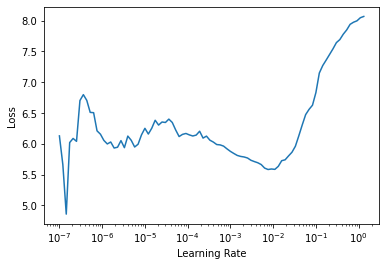

In [ ]:
learn.lr_find(suggestions=True)

We are going to train the network using the One-Cycle Policy. It consist of training the model using a cycle of two equal lenght, one going from a lower training rate to an higher one and then going from this max learning rate (defined by the user in the previous step) to a lower rate again. The lower rate can be ten times lower. The lower learning rates at the beginning are used to warm-up the training, while the higher rates at the medium of the cycle have a regularisation effect, that prevents the model from overfitting. Finally, with rates decreasing again allows the model to find a local minimum. This policy proved to provide a more efficient training, reaching high performances with much less epochs than traditional training.

Source: https://sgugger.github.io/the-1cycle-policy.html

In [ ]:
learn.fit_one_cycle(5, lr_max=3e-4) #train with 5 epochs and learning rate suggested

epoch,train_loss,valid_loss,time
0,2.389941,2.142708,10:30
1,1.672763,1.587552,10:29
2,1.232201,1.267986,10:29
3,1.014961,1.160485,10:29
4,0.928559,1.160716,10:28


In [ ]:
learn.freeze_to(-2) #defreeze the encoder weights of the model

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:54: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=3.0199516913853586e-06, lr_steep=4.786300905834651e-06)

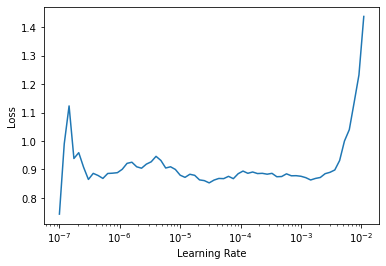

In [ ]:
learn.lr_find(suggestions=True) #run again the lr_find function after the first 5 epochs to adjust the learning rate

In [ ]:
learn.fit_one_cycle(5, lr_max=4e-6) #retrain with additional 5 epochs and new suggested learning rate

epoch,train_loss,valid_loss,time
0,0.919948,1.158808,12:28
1,0.842894,1.156203,12:28
2,0.772340,1.154688,12:29
3,0.821936,1.152016,12:30
4,0.831617,1.152321,12:28


In [ ]:
learn.export(fname='export_2_1.pkl') #export the model to a file, in order to use it afterwards for inference

#### Evaluation

In this part, we are going to evaluate the model produced using the test set we created before. This set is composed of about 1500 data points.

In [ ]:
df_test_2_1 = df_test.copy()

In [ ]:
n_rows = df_test_2_1.shape[0]

In [ ]:
n_rows

1562

In this code, we are automatically generating the summaries for all the texts present in the test set, storing them in a list and merging the results to the test set itself.

In [ ]:
%%time
results_test = []
for i in range(0,n_rows):
  pred = learn.blurr_generate(df_test_2_1.iloc[i,1], min_length = 100, max_length = 300)
  results_test.append(str(pred))

CPU times: user 40min 12s, sys: 3min 51s, total: 44min 3s
Wall time: 44min 4s


In [ ]:
df_test_2_1['pred'] = results_test

In [ ]:
df_test_2_1.head(2)

,summary,new_text,pred
14118,"Drill Now Act of 2008 Amends the Department of the Interior, Environment, and Related Agencies Appropriations Act, 2008 to repeal its prohibitions against oil and natural gas preleasing and leasing activities in specified offshore areas, including the North Atlantic, the eastern Gulf of Mexico, and the MidAtlantic and South Atlantic planning areas.Declares that the United States reserves the right to designate national defense areas on the outer Continental Shelf .Authorizes the Secretary of the Interior (Secretary) to conduct leasing, preleasing, and related activities for any opened are...","SECTION 1. SHORT TITLE. This Act may be cited as the Drill Now Act of 2008.SEC. 2. DEFINITIONS. In this Act: Opened area.The term opened area means any area of the outer Continental shelf that before the date of enactment of this Act, was closed to oil or gas leasing; and as of the date of enactment of this Act, is made available for leasing pursuant to section 3 and the amendments made by that section. Secretary.The term Secretary means the Secretary of the Interior.SEC. 3. LEASING ON OUTER CONTINENTAL SHELF. Opening New Offshore Areas to Oil and Gas Development. In general.Sections 104 a...","[' Drill Now Act of 2008 Amends the Department of the Interior, Environment, and Related Agencies Appropriations Act, 2008 to authorize the Secretary of Energy to conduct leasing, preleasing, and related activities for any opened area before June 30, 2012, notwithstanding the omission of the opened area from the Outer Continental Shelf leasing program developed pursuant to the OCS and from all other leased tracts in any other area for which leases are entered into after enactment of this Act, as follows: 50 percent in the general fund of the Treasury; 50 in a special account in the Trea..."
17891,"Virgin Islands Visa Waiver Act of 2012 Amends the Immigration and Nationality Act to establish a visa waiver program for the United States Virgin Islands for a national of a country that is a member or an associate member of the Caribbean Community (CARICOM) listed in regulations under this Act and who is applying for admission as a nonimmigrant business or pleasure visitor solely for entry into and stay in the United States Virgin Islands for not more than 30 days, if the Secretary of Homeland Security determines that such waiver does not represent a threat to the welfare or security of...","SECTION 1. SHORT TITLE. This Act may be cited as the Virgin Islands Visa Waiver Act of 2012.SEC. 2. VIRGIN ISLANDS VISA WAIVER PROGRAM. In General.Section 212 of the Immigration and Nationality Act (8 U.S.C. 1182 is amended by amending the subsection heading to read as follows: Guam, Northern Mariana Islands, and Virgin Islands Visa Waiver Programs.; and by adding at the end the following: Virgin islands visa waiver program. In general.The requirement of subsection may be waived by the Secretary of Homeland Security, in the case of an alien who is a national of a country described in subpa...","[' Virgin Islands Visa Waiver Act of 2012 Amends the Immigration and Nationality Act to authorize the Secretary of Homeland Security, in the case of an alien who is a national of a country that is a member or an associate member of the Caribbean Community and is applying for admission as a nonimmigrant visitor for business or pleasure and solely for entry into and stay in the United States Virgin Islands for a period not to exceed 30 days, if the Secretary determines that such a waiver does not represent a threat to the U.S. or its territories and commonwealths welfare, safety, or securit..."


In this section, we are going to introduce and calculate the Rouge Metric, which is a specific NLP metric used to evaluate the results of text summarisation. This metric is evaluating the similarity between the human generated summaries and the machine generated ones, in terms of number of words they have in common. We chose 3 types of Rouge scores:

  * Rouge-1: takes into consideration for the calculation the number of individual words the two summaries have in common;
  * Rouge-2: takes into consideration for the calculation the number of bi-grams the two summaries have in common;
  * Rouge-L: takes into consideration for the calculation the longest common subsequences between the two summaries.

Recall: Number of overlapping words between the two summaries divided by the number of words in the human generated summary

Precision: Recall: Number of overlapping words between the two summaries divided by the number of words in the model generated summary

F score: Combination of precision and recall

Source: https://www.freecodecamp.org/news/what-is-rouge-and-how-it-works-for-evaluation-of-summaries-e059fb8ac840/#:~:text=ROUGE%20stands%20for%20Recall%2DOriented,as%20well%20as%20machine%20translations.&text=If%20we%20consider%20just%20the,and%20reference%20summary%20is%206.

In [ ]:
rouge = Rouge()

Here we are calculating the scores for each pair of summaries (machine and human generated) in the test set and store the results in a list.

In [ ]:
results_rouge = []
for i in range(0,n_rows):
  scores = rouge.get_scores(df_test_2_1['pred'].iloc[i], df_test_2_1['summary'].iloc[i])
  results_rouge.append(scores)

In [ ]:
results_rouge

[[{'rouge-1': {'f': 0.5706521689508508, 'p': 0.625, 'r': 0.525},
   'rouge-2': {'f': 0.3497267709945057,
    'p': 0.38323353293413176,
    'r': 0.32160804020100503},
   'rouge-l': {'f': 0.46288209115005435, 'p': 0.53, 'r': 0.4108527131782946}}],
 [{'rouge-1': {'f': 0.5886075904576591,
    'p': 0.8691588785046729,
    'r': 0.4449760765550239},
   'rouge-2': {'f': 0.46496814839384976,
    'p': 0.6886792452830188,
    'r': 0.35096153846153844},
   'rouge-l': {'f': 0.6091953975373234, 'p': 0.7794117647058824, 'r': 0.5}}],
 [{'rouge-1': {'f': 0.4228571383157551,
    'p': 0.32456140350877194,
    'r': 0.6065573770491803},
   'rouge-2': {'f': 0.2774566428681213, 'p': 0.21238938053097345, 'r': 0.4},
   'rouge-l': {'f': 0.3437499953527833,
    'p': 0.2716049382716049,
    'r': 0.46808510638297873}}],
 [{'rouge-1': {'f': 0.6999999950125001,
    'p': 0.7368421052631579,
    'r': 0.6666666666666666},
   'rouge-2': {'f': 0.5050505000632589,
    'p': 0.5319148936170213,
    'r': 0.4807692307692308},

In [ ]:
dict_test = results_rouge[0][0]

In [ ]:
dict_test['rouge-1']

In [ ]:
result_rouge_1 = []
result_rouge_2 = []
result_rouge_L = []
for i in range(0,100):
  dict_var = results_rouge[i][0] #extract the dictionary containing the rouge values
  rouge_1 = dict_var['rouge-1']['f'] #store the f value of the rouge-1 metric
  rouge_2 = dict_var['rouge-2']['f'] #store the f value of the rouge-1 metric
  rouge_L = dict_var['rouge-l']['f'] #store the f value of the rouge-1 metric
  result_rouge_1.append(rouge_1) #store the value in the list
  result_rouge_2.append(rouge_2) #store the value in the list
  result_rouge_L.append(rouge_L) #store the value in the list

Finally, here we are calculating the average for each one of the 3 metrics selected.

In [ ]:
import numpy as np

In [ ]:
np.mean(result_rouge_1)

0.4948231200995318

In [ ]:
np.mean(result_rouge_2)

0.311927783699999

In [ ]:
np.mean(result_rouge_L)

0.46287617650002544

### Scenario 2.2: Batch Size = 4

#### Modelling

Here we are creating the architecture, model, tokenizer and configuration. Bewteen the different typologies of BART model, we are going to use the "smaller" one, called "bart-base", because of GPU limitations related to Google Colab.

In [ ]:
pretrained_model_name = "facebook/bart-base"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In this part, we are preparing the input data that we will use to feed the model. More specifically, we are defining some parameters such as the maximum input length of the text and of the summaries and the batch size.

In [ ]:
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='summarization'); text_gen_kwargs

{'bad_words_ids': None,
 'bos_token_id': 0,
 'decoder_start_token_id': 2,
 'diversity_penalty': 0.0,
 'do_sample': False,
 'early_stopping': True,
 'eos_token_id': 2,
 'length_penalty': 1.0,
 'max_length': 128,
 'min_length': 12,
 'no_repeat_ngram_size': 3,
 'num_beam_groups': 1,
 'num_beams': 4,
 'num_return_sequences': 1,
 'pad_token_id': 1,
 'repetition_penalty': 1.0,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'use_cache': True}

In [ ]:
hf_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, 
                                              max_length=1000, max_tgt_length=300, text_gen_kwargs=text_gen_kwargs)

blocks = (HF_Seq2SeqBlock(before_batch_tfm=hf_batch_tfm), noop)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('new_text'), #variable containing the full text of the law
                   get_y=ColReader('summary'), #variable containing the summary text of the law
                   splitter=RandomSplitter()) #this function performs a train/validation split of the input data, with 0.2 for validation

Here we are creating the dataloader, taking the training dataframe as input and defining 4 as batch size.

In [ ]:
dls = dblock.dataloaders(df_train, bs=4) #batch size = 4

Here we can see the input data splitted between training and validation.

In [ ]:
len(dls.train.items), len(dls.valid.items)

(4999, 1249)

#### Training

In this section the training of the model is performed. First of all, we are defining the Learner, which takes as input the dataloader and the model previously defined, as well as the optimisation and loss functions. Very interesting is the "seq2seq_splitter" function, which defines the splitting of the model in different parameters groups, in order to be able to freeze and unfreeze the different layers of the model. In the case of BART model, these parameters groups are: Embeddings, Model-Encoder and Model-Decoder. In this scenario, we are going to leave the parameter group related to the decoder unfrozen for half of the epochs, so only the wights related to the decoder will be left trainable. Then, for additional 5 epochs we are going to unfreeze also the weights related to the encoder part of the model.

In [ ]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]

learn = Learner(dls, #input data
                model, #bart model
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.create_opt() #create an optimizer with default hyper-parameters
learn.freeze() #leave only the decoder layers unfrozen

In [ ]:
print(model)

With the "lr_find" function, we are going to make a mock training to have a simulation of the effect of different learning rates on the loss of the model, in order to find the optimal learnign rate to be used in the training. A rule to choose the optimal maximum learning rate is to take a learning rate before the minimum, where the loss still improves.

Source: https://fastai1.fast.ai/callbacks.one_cycle.html

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:54: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.13182567358016967, lr_steep=1.0964782238006592)

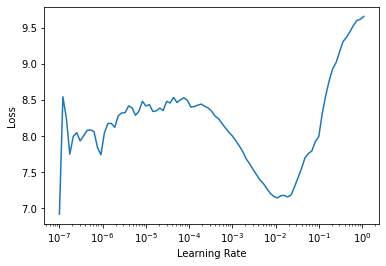

In [ ]:
learn.lr_find(suggestions=True)

We are going to train the network using the One-Cycle Policy. It consist of training the model using a cycle of two equal lenght, one going from a lower training rate to an higher one and then going from this max learning rate (defined by the user in the previous step) to a lower rate again. The lower rate can be ten times lower. The lower learning rates at the beginning are used to warm-up the training, while the higher rates at the medium of the cycle have a regularisation effect, that prevents the model from overfitting. Finally, with rates decreasing again allows the model to find a local minimum. This policy proved to provide a more efficient training, reaching high performances with much less epochs than traditional training.

Source: https://sgugger.github.io/the-1cycle-policy.html

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-3) #train with 5 epochs and learning rate suggested

epoch,train_loss,valid_loss,time
0,2.511590,2.238570,07:59
1,1.561420,1.321522,07:54
2,1.069111,1.068016,07:58
3,0.892183,0.959587,07:52
4,0.719473,0.957751,07:53


In [ ]:
learn.freeze_to(-2) #defreeze the encoder weights of the model

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:54: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=7.585775847473997e-07)

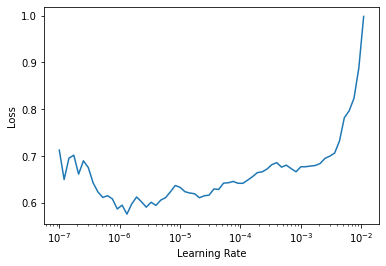

In [ ]:
learn.lr_find(suggestions=True) #run again the lr_find function after the first 5 epochs to adjust the learning rate

In [ ]:
learn.fit_one_cycle(5, lr_max=5e-7) #retrain with additional 5 epochs and new suggested learning rate

epoch,train_loss,valid_loss,time
0,0.681794,0.960119,09:07
1,0.718905,0.960592,09:11
2,0.718094,0.960635,09:04
3,0.675664,0.960953,09:00
4,0.707694,0.960911,09:00


In [ ]:
learn.export(fname='export_2_2.pkl') #export the model to a file, in order to use it afterwards for inference

In [ ]:
learn.blurr_generate(df_test.iloc[0,1], min_length = 100, max_length = 300) #example of generated text

[' Drill Drill Now Act of 2008  Authorizes the Secretary of the Interior to conduct leasing, preleasing, and related activities for any opened area before June 30, 2012, notwithstanding the omission of the opened area from the Outer Continental Shelf leasing program developed pursuant to the Land and Water Conservation Fund Act of 1965 and from all other leased tracts in any other area for which leases are entered into after the date of enactment of this Act, as follows:  50 percent in the general fund of the Treasury; and  50 in a special account in the Treasury, for allocation by the Secretary among the states in accordance with this Act.Requires the Secretary to:  deposit rentals, royalties, bonus bids, and other sums due and payable from any leased tract within an opened area and from any other leased tract in an open area, and  deposit specified fees from leases entered into under this Act among the States.']

#### Evaluation

In this part, we are going to evaluate the model produced using the test set we created before. This set is composed of about 1500 data points.

In [ ]:
df_test_2_2 = df_test.copy()

In [ ]:
n_rows = df_test_2_2.shape[0]

In [ ]:
n_rows

1562

In this code, we are automatically generating the summaries for all the texts present in the test set, storing them in a list and merging the results to the test set itself.

In [ ]:
%%time
results_test = []
for i in range(0,n_rows):
  pred = learn.blurr_generate(df_test_2_2.iloc[i,1], min_length = 100, max_length = 300)
  results_test.append(str(pred))

CPU times: user 48min 8s, sys: 6min 58s, total: 55min 6s
Wall time: 55min 6s


In [ ]:
df_test_2_2['pred'] = results_test

In [ ]:
df_test_2_2.head(2)

,summary,new_text,pred
14118,"Drill Now Act of 2008 Amends the Department of the Interior, Environment, and Related Agencies Appropriations Act, 2008 to repeal its prohibitions against oil and natural gas preleasing and leasing activities in specified offshore areas, including the North Atlantic, the eastern Gulf of Mexico, and the MidAtlantic and South Atlantic planning areas.Declares that the United States reserves the right to designate national defense areas on the outer Continental Shelf .Authorizes the Secretary of the Interior (Secretary) to conduct leasing, preleasing, and related activities for any opened are...","SECTION 1. SHORT TITLE. This Act may be cited as the Drill Now Act of 2008.SEC. 2. DEFINITIONS. In this Act: Opened area.The term opened area means any area of the outer Continental shelf that before the date of enactment of this Act, was closed to oil or gas leasing; and as of the date of enactment of this Act, is made available for leasing pursuant to section 3 and the amendments made by that section. Secretary.The term Secretary means the Secretary of the Interior.SEC. 3. LEASING ON OUTER CONTINENTAL SHELF. Opening New Offshore Areas to Oil and Gas Development. In general.Sections 104 a...","[' Drill Drill Now Act of 2008 Authorizes the Secretary of the Interior to conduct leasing, preleasing, and related activities for any opened area before June 30, 2012, notwithstanding the omission of the opened area from the Outer Continental Shelf leasing program developed pursuant to the Land and Water Conservation Fund Act of 1965 and from all other leased tracts in any other area for which leases are entered into after the date of enactment of this Act, as follows: 50 percent in the general fund of the Treasury; and 50 in a special account in the Treasury, for allocation by the Sec..."
17891,"Virgin Islands Visa Waiver Act of 2012 Amends the Immigration and Nationality Act to establish a visa waiver program for the United States Virgin Islands for a national of a country that is a member or an associate member of the Caribbean Community (CARICOM) listed in regulations under this Act and who is applying for admission as a nonimmigrant business or pleasure visitor solely for entry into and stay in the United States Virgin Islands for not more than 30 days, if the Secretary of Homeland Security determines that such waiver does not represent a threat to the welfare or security of...","SECTION 1. SHORT TITLE. This Act may be cited as the Virgin Islands Visa Waiver Act of 2012.SEC. 2. VIRGIN ISLANDS VISA WAIVER PROGRAM. In General.Section 212 of the Immigration and Nationality Act (8 U.S.C. 1182 is amended by amending the subsection heading to read as follows: Guam, Northern Mariana Islands, and Virgin Islands Visa Waiver Programs.; and by adding at the end the following: Virgin islands visa waiver program. In general.The requirement of subsection may be waived by the Secretary of Homeland Security, in the case of an alien who is a national of a country described in subpa...","[' Virgin Virgin Islands Visa Waiver Act of 2012 Amends the Immigration and Nationality Act to authorize the Secretary of Homeland Security, in the case of an alien who is a national of a country described in this Act and who is applying for admission as a nonimmigrant visitor for business or pleasure and solely for entry into and stay in the U.S. Virgin Islands for at least 30 days, if the Secretary determines that such a waiver does not pose a threat to the welfare, safety, or security of the United States or its territories and commonwealths. Prohibits the Secretary from being provided..."


In this section, we are going to introduce and calculate the Rouge Metric, which is a specific NLP metric used to evaluate the results of text summarisation. This metric is evaluating the similarity between the human generated summaries and the machine generated ones, in terms of number of words they have in common. We chose 3 types of Rouge scores:

  * Rouge-1: takes into consideration for the calculation the number of individual words the two summaries have in common;
  * Rouge-2: takes into consideration for the calculation the number of bi-grams the two summaries have in common;
  * Rouge-L: takes into consideration for the calculation the longest common subsequences between the two summaries.

For each of these 3 scores we calculated the precision, recall and the F score. We decided to take the F score because it is a good balance between precision and recall.

Recall: Number of overlapping words between the two summaries divided by the number of words in the human generated summary

Precision: Recall: Number of overlapping words between the two summaries divided by the number of words in the model generated summary

F score: Combination of precision and recall

Source: https://www.freecodecamp.org/news/what-is-rouge-and-how-it-works-for-evaluation-of-summaries-e059fb8ac840/#:~:text=ROUGE%20stands%20for%20Recall%2DOriented,as%20well%20as%20machine%20translations.&text=If%20we%20consider%20just%20the,and%20reference%20summary%20is%206.

In [ ]:
rouge = Rouge()

Here we are calculating the scores for each pair of summaries (machine and human generated) in the test set and store the results in a list.

In [ ]:
results_rouge = []
for i in range(0,n_rows):
  scores = rouge.get_scores(df_test_2_2['pred'].iloc[i], df_test_2_2['summary'].iloc[i])
  results_rouge.append(scores)

In [ ]:
results_rouge

[[{'rouge-1': {'f': 0.5125348140067195, 'p': 0.5786163522012578, 'r': 0.46},
   'rouge-2': {'f': 0.2801120398838752,
    'p': 0.31645569620253167,
    'r': 0.25125628140703515},
   'rouge-l': {'f': 0.4253393616559858,
    'p': 0.5108695652173914,
    'r': 0.3643410852713178}}],
 [{'rouge-1': {'f': 0.6214099167127733,
    'p': 0.6839080459770115,
    'r': 0.569377990430622},
   'rouge-2': {'f': 0.4041994701078114,
    'p': 0.44508670520231214,
    'r': 0.3701923076923077},
   'rouge-l': {'f': 0.5673076873095415,
    'p': 0.5784313725490197,
    'r': 0.5566037735849056}}],
 [{'rouge-1': {'f': 0.4666666618408889,
    'p': 0.39325842696629215,
    'r': 0.5737704918032787},
   'rouge-2': {'f': 0.3513513465303142,
    'p': 0.29545454545454547,
    'r': 0.43333333333333335},
   'rouge-l': {'f': 0.36697247215890927,
    'p': 0.3225806451612903,
    'r': 0.425531914893617}}],
 [{'rouge-1': {'f': 0.5416666617447917,
    'p': 0.48148148148148145,
    'r': 0.6190476190476191},
   'rouge-2': {'f': 

Here we are extracting the results of each rouge metric from the previous dictionary and storing them in other lists.

In [ ]:
result_rouge_1 = []
result_rouge_2 = []
result_rouge_L = []
for i in range(0,100):
  dict_var = results_rouge[i][0] #extract the dictionary containing the rouge values
  rouge_1 = dict_var['rouge-1']['f'] #store the f value of the rouge-1 metric
  rouge_2 = dict_var['rouge-2']['f'] #store the f value of the rouge-1 metric
  rouge_L = dict_var['rouge-l']['f'] #store the f value of the rouge-1 metric
  result_rouge_1.append(rouge_1) #store the value in the list
  result_rouge_2.append(rouge_2) #store the value in the list
  result_rouge_L.append(rouge_L) #store the value in the list

Finally, here we are calculating the average for each one of the 3 metrics selected.

In [ ]:
import numpy as np

In [ ]:
np.mean(result_rouge_1)

0.4974145833369466

In [ ]:
np.mean(result_rouge_2)

0.30621412995508335

In [ ]:
np.mean(result_rouge_L)

0.4564220221679431

## Scenario 3: Training 10 epochs with both Encoder e Decoder Unfreezed

### Scenario 3.1: Batch Size = 2

#### Modelling

Here we are creating the architecture, model, tokenizer and configuration. Bewteen the different typologies of BART model, we are going to use the "smaller" one, called "bart-base", because of GPU limitations related to Google Colab.

In [ ]:
pretrained_model_name = "facebook/bart-base"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In this part, we are preparing the input data that we will use to feed the model. More specifically, we are defining some parameters such as the maximum input length of the text and of the summaries and the batch size.

In [ ]:
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='summarization'); text_gen_kwargs

{'bad_words_ids': None,
 'bos_token_id': 0,
 'decoder_start_token_id': 2,
 'diversity_penalty': 0.0,
 'do_sample': False,
 'early_stopping': True,
 'eos_token_id': 2,
 'length_penalty': 1.0,
 'max_length': 128,
 'min_length': 12,
 'no_repeat_ngram_size': 3,
 'num_beam_groups': 1,
 'num_beams': 4,
 'num_return_sequences': 1,
 'pad_token_id': 1,
 'repetition_penalty': 1.0,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'use_cache': True}

In [ ]:
hf_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, 
                                              max_length=1000, max_tgt_length=300, text_gen_kwargs=text_gen_kwargs)

blocks = (HF_Seq2SeqBlock(before_batch_tfm=hf_batch_tfm), noop)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('new_text'), #variable containing the full text of the law
                   get_y=ColReader('summary'), #variable containing the summary text of the law
                   splitter=RandomSplitter()) #this function performs a train/validation split of the input data, with 0.2 for validation

Here we are creating the dataloader, taking the training dataframe as input and defining 2 as batch size.

In [ ]:
dls = dblock.dataloaders(df_train, bs=2) #batch size = 2

Here we can see the input data splitted between training and validation.

In [ ]:
len(dls.train.items), len(dls.valid.items)

#### Training

In this section the training of the model is performed. First of all, we are defining the Learner, which takes as input the dataloader and the model previously defined, as well as the optimisation and loss functions. Very interesting is the "seq2seq_splitter" function, which defines the splitting of the model in different parameters groups, in order to be able to freeze and unfreeze the different layers of the model. In the case of BART model, these parameters groups are: Embeddings, Model-Encoder and Model-Decoder. In this scenario, we are going to leave the parameter group related to both the encoder and decoder unfrozen for the entire training, so  the weights related to both the encoder and decoder will be left trainable.

In [ ]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]

learn = Learner(dls, #input data
                model, #bart model
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.create_opt() #create an optimizer with default hyper-parameters
learn.freeze_to(-2) #keep the encoder and decoder layers unfrozen

In [ ]:
print(model)

With the "lr_find" function, we are going to make a mock training to have a simulation of the effect of different learning rates on the loss of the model, in order to find the optimal learnign rate to be used in the training. A rule to choose the optimal maximum learning rate is to take a learning rate before the minimum, where the loss still improves.

Source: https://fastai1.fast.ai/callbacks.one_cycle.html

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:54: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.2290867567062378, lr_steep=1.9054607152938843)

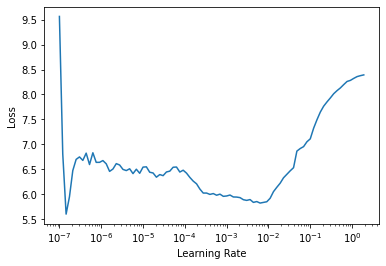

In [ ]:
learn.lr_find(suggestions=True)

We are going to train the network using the One-Cycle Policy. It consist of training the model using a cycle of two equal lenght, one going from a lower training rate to an higher one and then going from this max learning rate (defined by the user in the previous step) to a lower rate again. The lower rate can be ten times lower. The lower learning rates at the beginning are used to warm-up the training, while the higher rates at the medium of the cycle have a regularisation effect, that prevents the model from overfitting. Finally, with rates decreasing again allows the model to find a local minimum. This policy proved to provide a more efficient training, reaching high performances with much less epochs than traditional training.

Source: https://sgugger.github.io/the-1cycle-policy.html

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-4) #train with 5 epochs and learning rate suggested

epoch,train_loss,valid_loss,time
0,2.450073,2.147571,12:16
1,1.962796,1.899833,12:15
2,1.792082,1.712613,12:16
3,1.548307,1.628214,12:13
4,1.471071,1.615231,12:14


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:54: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=6.309573450380412e-07)

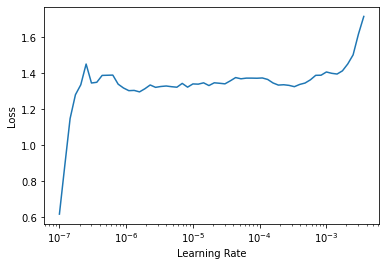

In [ ]:
learn.lr_find(suggestions=True) #run again the lr_find function after the first 5 epochs to adjust the learning rate

In [ ]:
learn.fit_one_cycle(5, lr_max=3e-7) #train with 5 additional epochs and learning rate suggested

epoch,train_loss,valid_loss,time
0,1.445495,1.615420,12:15
1,1.469395,1.615258,12:14
2,1.419055,1.615095,12:13
3,1.459111,1.614528,12:13
4,1.410607,1.614585,12:14


In [ ]:
learn.export(fname='export_3_1.pkl') #export the model to a file, in order to use it afterwards for inference

In [ ]:
text = learn.blurr_generate(df_test.iloc[0,1], min_length = 100, max_length = 300) #example of generated text

[' Drill Drill Now Act of 2008  Authorizes the Secretary of the Interior to conduct leasing, preleasing, and related activities for any opened area before June 30, 2012, notwithstanding the omission of the opened area from the Outer Continental Shelf leasing program developed pursuant to the Land and Water Conservation Fund Act of 1965 and from all other leased tracts in any other area for which leases are entered into after the date of enactment of this Act, as follows:  50 percent in the general fund of the Treasury; and  50 in a special account in the Treasury, for allocation by the Secretary among the states in accordance with this Act.Requires the Secretary to:  deposit rentals, royalties, bonus bids, and other sums due and payable from any leased tract within an opened area and from any other leased tract in an open area, and  deposit specified fees from leases entered into under this Act among the States.']

In [ ]:
str(text)

"[' Drill Drill Now Act of 2008  Authorizes the Secretary of the Interior to conduct leasing, preleasing, and related activities for any opened area before June 30, 2012, notwithstanding the omission of the opened area from the Outer Continental Shelf leasing program developed pursuant to the Land and Water Conservation Fund Act of 1965 and from all other leased tracts in any other area for which leases are entered into after the date of enactment of this Act, as follows:  50 percent in the general fund of the Treasury; and  50 in a special account in the Treasury, for allocation by the Secretary among the states in accordance with this Act.Requires the Secretary to:  deposit rentals, royalties, bonus bids, and other sums due and payable from any leased tract within an opened area and from any other leased tract in an open area, and  deposit specified fees from leases entered into under this Act among the States.']"

#### Evaluation

In this part, we are going to evaluate the model produced using the test set we created before. This set is composed of about 1500 data points.

In [ ]:
df_test_3_1 = df_test.copy()

In [ ]:
n_rows = df_test_3_1.shape[0]

In [ ]:
n_rows

1562

In this code, we are automatically generating the summaries for all the texts present in the test set, storing them in a list and merging the results to the test set itself.

In [ ]:
%%time
results_test = []
for i in range(0,n_rows):
  pred = learn.blurr_generate(df_test_3_1.iloc[i,1], min_length = 100, max_length = 300)
  results_test.append(str(pred))

CPU times: user 40min 27s, sys: 3min 51s, total: 44min 19s
Wall time: 44min 18s


In [ ]:
df_test_3_1['pred'] = results_test

In [ ]:
df_test_3_1.head(2)

,summary,new_text,pred
14118,"Drill Now Act of 2008 Amends the Department of the Interior, Environment, and Related Agencies Appropriations Act, 2008 to repeal its prohibitions against oil and natural gas preleasing and leasing activities in specified offshore areas, including the North Atlantic, the eastern Gulf of Mexico, and the MidAtlantic and South Atlantic planning areas.Declares that the United States reserves the right to designate national defense areas on the outer Continental Shelf .Authorizes the Secretary of the Interior (Secretary) to conduct leasing, preleasing, and related activities for any opened are...","SECTION 1. SHORT TITLE. This Act may be cited as the Drill Now Act of 2008.SEC. 2. DEFINITIONS. In this Act: Opened area.The term opened area means any area of the outer Continental shelf that before the date of enactment of this Act, was closed to oil or gas leasing; and as of the date of enactment of this Act, is made available for leasing pursuant to section 3 and the amendments made by that section. Secretary.The term Secretary means the Secretary of the Interior.SEC. 3. LEASING ON OUTER CONTINENTAL SHELF. Opening New Offshore Areas to Oil and Gas Development. In general.Sections 104 a...","[' Drill Now Act of 2008 Amends the Department of the Interior, Environment, and Related Agencies Appropriations Act, 2008 to repeal specified provisions of the Gulf of Mexico Energy Security Act of 2006 relating to national defense areas on the outer Continental Shelf.Authorizes the Secretary of Defense, with the approval of the President, to conduct leasing, preleasing, and related activities for any opened area before June 30, 2012, notwithstanding the omission of the opened area from the Outer Continental Herlf leasing program developed pursuant to the OCSL Lands Act for such period.R..."
17891,"Virgin Islands Visa Waiver Act of 2012 Amends the Immigration and Nationality Act to establish a visa waiver program for the United States Virgin Islands for a national of a country that is a member or an associate member of the Caribbean Community (CARICOM) listed in regulations under this Act and who is applying for admission as a nonimmigrant business or pleasure visitor solely for entry into and stay in the United States Virgin Islands for not more than 30 days, if the Secretary of Homeland Security determines that such waiver does not represent a threat to the welfare or security of...","SECTION 1. SHORT TITLE. This Act may be cited as the Virgin Islands Visa Waiver Act of 2012.SEC. 2. VIRGIN ISLANDS VISA WAIVER PROGRAM. In General.Section 212 of the Immigration and Nationality Act (8 U.S.C. 1182 is amended by amending the subsection heading to read as follows: Guam, Northern Mariana Islands, and Virgin Islands Visa Waiver Programs.; and by adding at the end the following: Virgin islands visa waiver program. In general.The requirement of subsection may be waived by the Secretary of Homeland Security, in the case of an alien who is a national of a country described in subpa...","[' Virgin Islands Visa Waiver Act of 2012 Amends the Immigration and Nationality Act to authorize the Secretary of Homeland Security , in the case of an alien who is a national of a country that is a member or an associate member of the Caribbean Community (CARICOM), to waive any right to: review or appeal an immigration officers determination as to the admissibility of the alien at the port of entry into the United States; or contest, other than on the basis of an application for withholding of removal or asylum, any action for removal.Requires the Secretary to consider all factors tha..."


In this section, we are going to introduce and calculate the Rouge Metric, which is a specific NLP metric used to evaluate the results of text summarisation. This metric is evaluating the similarity between the human generated summaries and the machine generated ones, in terms of number of words they have in common. We chose 3 types of Rouge scores:

  * Rouge-1: takes into consideration for the calculation the number of individual words the two summaries have in common;
  * Rouge-2: takes into consideration for the calculation the number of bi-grams the two summaries have in common;
  * Rouge-L: takes into consideration for the calculation the longest common subsequences between the two summaries.

For each of these 3 scores we calculated the precision, recall and the F score. We decided to take the F score because it is a good balance between precision and recall.

Recall: Number of overlapping words between the two summaries divided by the number of words in the human generated summary

Precision: Recall: Number of overlapping words between the two summaries divided by the number of words in the model generated summary

F score: Combination of precision and recall

Source: https://www.freecodecamp.org/news/what-is-rouge-and-how-it-works-for-evaluation-of-summaries-e059fb8ac840/#:~:text=ROUGE%20stands%20for%20Recall%2DOriented,as%20well%20as%20machine%20translations.&text=If%20we%20consider%20just%20the,and%20reference%20summary%20is%206.

In [ ]:
rouge = Rouge()

Here we are calculating the scores for each pair of summaries (machine and human generated) in the test set and store the results in a list.

In [ ]:
results_rouge = []
for i in range(0,n_rows):
  scores = rouge.get_scores(df_test_3_1['pred'].iloc[i], df_test_3_1['summary'].iloc[i])
  results_rouge.append(scores)

In [ ]:
results_rouge

[[{'rouge-1': {'f': 0.5876543159884166, 'p': 0.5804878048780487, 'r': 0.595},
   'rouge-2': {'f': 0.3374689776310426,
    'p': 0.3333333333333333,
    'r': 0.3417085427135678},
   'rouge-l': {'f': 0.4609374950003052,
    'p': 0.4645669291338583,
    'r': 0.4573643410852713}}],
 [{'rouge-1': {'f': 0.6536585315872696,
    'p': 0.6666666666666666,
    'r': 0.6411483253588517},
   'rouge-2': {'f': 0.44117646559015766, 'p': 0.45, 'r': 0.4326923076923077},
   'rouge-l': {'f': 0.54385964414743,
    'p': 0.5081967213114754,
    'r': 0.5849056603773585}}],
 [{'rouge-1': {'f': 0.5031446493588071,
    'p': 0.40816326530612246,
    'r': 0.6557377049180327},
   'rouge-2': {'f': 0.30573247935413206, 'p': 0.24742268041237114, 'r': 0.4},
   'rouge-l': {'f': 0.4869565169058602,
    'p': 0.4117647058823529,
    'r': 0.5957446808510638}}],
 [{'rouge-1': {'f': 0.44635192637919285,
    'p': 0.40625,
    'r': 0.49523809523809526},
   'rouge-2': {'f': 0.22510822015779328, 'p': 0.2047244094488189, 'r': 0.25},

Here we are extracting the results of each rouge metric from the previous dictionary and storing them in other lists.

In [ ]:
result_rouge_1 = []
result_rouge_2 = []
result_rouge_L = []
for i in range(0,100):
  dict_var = results_rouge[i][0] #extract the dictionary containing the rouge values
  rouge_1 = dict_var['rouge-1']['f'] #store the f value of the rouge-1 metric
  rouge_2 = dict_var['rouge-2']['f'] #store the f value of the rouge-1 metric
  rouge_L = dict_var['rouge-l']['f'] #store the f value of the rouge-1 metric
  result_rouge_1.append(rouge_1) #store the value in the list
  result_rouge_2.append(rouge_2) #store the value in the list
  result_rouge_L.append(rouge_L) #store the value in the list

Finally, here we are calculating the average for each one of the 3 metrics selected.

In [ ]:
import numpy as np

In [ ]:
np.mean(result_rouge_1)

0.5119935742923942

In [ ]:
np.mean(result_rouge_2)

0.32729861573715296

In [ ]:
np.mean(result_rouge_L)

0.4899612482365817

### Scenario 3.2: Batch Size = 4

#### Modelling

Here we are creating the architecture, model, tokenizer and configuration. Bewteen the different typologies of BART model, we are going to use the "smaller" one, called "bart-base", because of GPU limitations related to Google Colab.

In [ ]:
pretrained_model_name = "facebook/bart-base"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In this part, we are preparing the input data that we will use to feed the model. More specifically, we are defining some parameters such as the maximum input length of the text and of the summaries and the batch size.

In [ ]:
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='summarization'); text_gen_kwargs

{'bad_words_ids': None,
 'bos_token_id': 0,
 'decoder_start_token_id': 2,
 'diversity_penalty': 0.0,
 'do_sample': False,
 'early_stopping': True,
 'eos_token_id': 2,
 'length_penalty': 1.0,
 'max_length': 128,
 'min_length': 12,
 'no_repeat_ngram_size': 3,
 'num_beam_groups': 1,
 'num_beams': 4,
 'num_return_sequences': 1,
 'pad_token_id': 1,
 'repetition_penalty': 1.0,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'use_cache': True}

In [ ]:
hf_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, 
                                              max_length=1000, max_tgt_length=300, text_gen_kwargs=text_gen_kwargs)

blocks = (HF_Seq2SeqBlock(before_batch_tfm=hf_batch_tfm), noop)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('new_text'), #variable containing the full text of the law
                   get_y=ColReader('summary'), #variable containing the summary text of the law
                   splitter=RandomSplitter()) #this function performs a train/validation split of the input data, with 0.2 for validation

Here we are creating the dataloader, taking the training dataframe as input and defining 4 as batch size.

In [ ]:
dls = dblock.dataloaders(df_train, bs=4) #batch size = 4

Here we can see the input data splitted between training and validation.

In [ ]:
len(dls.train.items), len(dls.valid.items)

(4999, 1249)

#### Training

In this section the training of the model is performed. First of all, we are defining the Learner, which takes as input the dataloader and the model previously defined, as well as the optimisation and loss functions. Very interesting is the "seq2seq_splitter" function, which defines the splitting of the model in different parameters groups, in order to be able to freeze and unfreeze the different layers of the model. In the case of BART model, these parameters groups are: Embeddings, Model-Encoder and Model-Decoder. In this scenario, we are going to leave the parameter group related to both the encoder and decoder unfrozen for the entire training, so  the weights related to both the encoder and decoder will be left trainable.

In [ ]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]

learn = Learner(dls, #input data
                model, #bart model
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.create_opt() #create an optimizer with default hyper-parameters
learn.freeze_to(-2) #keep the encoder and decoder layers unfrozen

In [ ]:
print(model)

With the "lr_find" function, we are going to make a mock training to have a simulation of the effect of different learning rates on the loss of the model, in order to find the optimal learnign rate to be used in the training. A rule to choose the optimal maximum learning rate is to take a learning rate before the minimum, where the loss still improves.

Source: https://fastai1.fast.ai/callbacks.one_cycle.html

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:54: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.13182567358016967, lr_steep=1.0964782238006592)

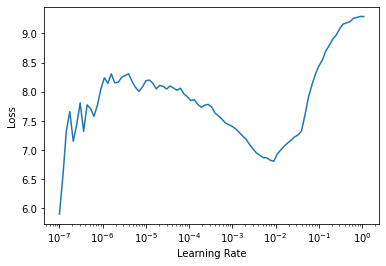

In [ ]:
learn.lr_find(suggestions=True)

We are going to train the network using the One-Cycle Policy. It consist of training the model using a cycle of two equal lenght, one going from a lower training rate to an higher one and then going from this max learning rate (defined by the user in the previous step) to a lower rate again. The lower rate can be ten times lower. The lower learning rates at the beginning are used to warm-up the training, while the higher rates at the medium of the cycle have a regularisation effect, that prevents the model from overfitting. Finally, with rates decreasing again allows the model to find a local minimum. This policy proved to provide a more efficient training, reaching high performances with much less epochs than traditional training.

Source: https://sgugger.github.io/the-1cycle-policy.html

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-4) #train with 5 epochs and learning rate suggested

epoch,train_loss,valid_loss,time
0,2.889948,2.591367,10:26
1,2.605956,2.361256,10:26
2,2.268001,2.203003,10:25
3,2.107402,2.118401,10:27
4,2.105629,2.109003,10:27


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:54: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.43651583790779114)

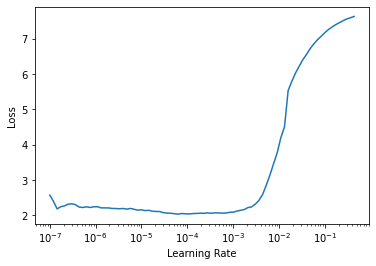

In [ ]:
learn.lr_find(suggestions=True) #run again the lr_find function after the first 5 epochs to adjust the learning rate

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-5) #train with 5 additional epochs and learning rate suggested

epoch,train_loss,valid_loss,time
0,3.588278,3.635781,10:27
1,2.429904,2.519341,10:27
2,2.041869,2.109944,10:28
3,2.000885,2.078281,10:27
4,1.984308,2.072778,10:27


In [ ]:
learn.export(fname='export_3_2.pkl') #export the model to a file, in order to use it afterwards for inference

In [ ]:
text = learn.blurr_generate(df_test.iloc[0,1], min_length = 100, max_length = 300) #example of generated text

[' Drill Now Act of 2008  Amends the Gulf of Mexico Energy Security Act of 2006 to authorize the Secretary of the Interior to conduct leasing, preleasing, and related activities for any opened area before June 30, 2012, notwithstanding the omission of the opened area from the Outer Continental Shelf  leasing program developed pursuant to the OCSL Lands Act.Requires the Secretary to deposit rentals, royalties, bonus bids, and other sums due and payable from any leased tract within an opened area and from all other leased tracts in any other area for which leases are entered into after enactment of this Act, as follows:  50 percent in the general fund of the Treasury; 50 in a special account in the Treasury for allocation by the Secretary among the States; and  50 in the special account for allocation among the states.']

In [ ]:
str(text)

"[' Drill Now Act of 2008  Amends the Gulf of Mexico Energy Security Act of 2006 to authorize the Secretary of the Interior to conduct leasing, preleasing, and related activities for any opened area before June 30, 2012, notwithstanding the omission of the opened area from the Outer Continental Shelf  leasing program developed pursuant to the OCSL Lands Act.Requires the Secretary to deposit rentals, royalties, bonus bids, and other sums due and payable from any leased tract within an opened area and from all other leased tracts in any other area for which leases are entered into after enactment of this Act, as follows:  50 percent in the general fund of the Treasury; 50 in a special account in the Treasury for allocation by the Secretary among the States; and  50 in the special account for allocation among the states.']"

#### Evaluation

In this part, we are going to evaluate the model produced using the test set we created before. This set is composed of about 1500 data points.

In [ ]:
df_test_3_2 = df_test.copy()

In [ ]:
n_rows = df_test_3_2.shape[0]

In [ ]:
n_rows

1562

In this code, we are automatically generating the summaries for all the texts present in the test set, storing them in a list and merging the results to the test set itself.

In [ ]:
%%time
results_test = []
for i in range(0,n_rows):
  pred = learn.blurr_generate(df_test_3_2.iloc[i,1], min_length = 100, max_length = 300)
  results_test.append(str(pred))

CPU times: user 42min 45s, sys: 3min 59s, total: 46min 45s
Wall time: 46min 45s


In [ ]:
df_test_3_2['pred'] = results_test

In [ ]:
df_test_3_2.head(2)

,summary,new_text,pred
14118,"Drill Now Act of 2008 Amends the Department of the Interior, Environment, and Related Agencies Appropriations Act, 2008 to repeal its prohibitions against oil and natural gas preleasing and leasing activities in specified offshore areas, including the North Atlantic, the eastern Gulf of Mexico, and the MidAtlantic and South Atlantic planning areas.Declares that the United States reserves the right to designate national defense areas on the outer Continental Shelf .Authorizes the Secretary of the Interior (Secretary) to conduct leasing, preleasing, and related activities for any opened are...","SECTION 1. SHORT TITLE. This Act may be cited as the Drill Now Act of 2008.SEC. 2. DEFINITIONS. In this Act: Opened area.The term opened area means any area of the outer Continental shelf that before the date of enactment of this Act, was closed to oil or gas leasing; and as of the date of enactment of this Act, is made available for leasing pursuant to section 3 and the amendments made by that section. Secretary.The term Secretary means the Secretary of the Interior.SEC. 3. LEASING ON OUTER CONTINENTAL SHELF. Opening New Offshore Areas to Oil and Gas Development. In general.Sections 104 a...","[' Drill Now Act of 2008 Amends the Gulf of Mexico Energy Security Act of 2006 to authorize the Secretary of the Interior to conduct leasing, preleasing, and related activities for any opened area before June 30, 2012, notwithstanding the omission of the opened area from the Outer Continental Shelf leasing program developed pursuant to the OCSL Lands Act.Requires the Secretary to deposit rentals, royalties, bonus bids, and other sums due and payable from any leased tract within an opened area and from all other leased tracts in any other area for which leases are entered into after enact..."
17891,"Virgin Islands Visa Waiver Act of 2012 Amends the Immigration and Nationality Act to establish a visa waiver program for the United States Virgin Islands for a national of a country that is a member or an associate member of the Caribbean Community (CARICOM) listed in regulations under this Act and who is applying for admission as a nonimmigrant business or pleasure visitor solely for entry into and stay in the United States Virgin Islands for not more than 30 days, if the Secretary of Homeland Security determines that such waiver does not represent a threat to the welfare or security of...","SECTION 1. SHORT TITLE. This Act may be cited as the Virgin Islands Visa Waiver Act of 2012.SEC. 2. VIRGIN ISLANDS VISA WAIVER PROGRAM. In General.Section 212 of the Immigration and Nationality Act (8 U.S.C. 1182 is amended by amending the subsection heading to read as follows: Guam, Northern Mariana Islands, and Virgin Islands Visa Waiver Programs.; and by adding at the end the following: Virgin islands visa waiver program. In general.The requirement of subsection may be waived by the Secretary of Homeland Security, in the case of an alien who is a national of a country described in subpa...","[' Virgin Islands Visa Waiver Act of 2012 Amends the Immigration and Nationality Act to authorize the Department of Homeland Security to waive the visa waiver requirement of a national of a country that is a member or associate member of the Caribbean Community (CARICOM) and who is applying for admission as a nonimmigrant visitor for business or pleasure and solely for entry into and stay in the U.S. Virgin Islands for a period not to exceed 30 days, if DHS determines that such waiver does not pose a threat to the welfare, safety, or security of the United States or its territories and c..."


In this section, we are going to introduce and calculate the Rouge Metric, which is a specific NLP metric used to evaluate the results of text summarisation. This metric is evaluating the similarity between the human generated summaries and the machine generated ones, in terms of number of words they have in common. We chose 3 types of Rouge scores:

  * Rouge-1: takes into consideration for the calculation the number of individual words the two summaries have in common;
  * Rouge-2: takes into consideration for the calculation the number of bi-grams the two summaries have in common;
  * Rouge-L: takes into consideration for the calculation the longest common subsequences between the two summaries.

For each of these 3 scores we calculated the precision, recall and the F score. We decided to take the F score because it is a good balance between precision and recall.

Recall: Number of overlapping words between the two summaries divided by the number of words in the human generated summary

Precision: Recall: Number of overlapping words between the two summaries divided by the number of words in the model generated summary

F score: Combination of precision and recall

Source: https://www.freecodecamp.org/news/what-is-rouge-and-how-it-works-for-evaluation-of-summaries-e059fb8ac840/#:~:text=ROUGE%20stands%20for%20Recall%2DOriented,as%20well%20as%20machine%20translations.&text=If%20we%20consider%20just%20the,and%20reference%20summary%20is%206.

In [ ]:
rouge = Rouge()

Here we are calculating the scores for each pair of summaries (machine and human generated) in the test set and store the results in a list.

In [ ]:
results_rouge = []
for i in range(0,n_rows):
  scores = rouge.get_scores(df_test_3_2['pred'].iloc[i], df_test_3_2['summary'].iloc[i])
  results_rouge.append(scores)

In [ ]:
results_rouge

[[{'rouge-1': {'f': 0.520467831401115, 'p': 0.6267605633802817, 'r': 0.445},
   'rouge-2': {'f': 0.27647058338079594,
    'p': 0.3333333333333333,
    'r': 0.23618090452261306},
   'rouge-l': {'f': 0.3813953440372093,
    'p': 0.47674418604651164,
    'r': 0.3178294573643411}}],
 [{'rouge-1': {'f': 0.5886075904576591,
    'p': 0.8691588785046729,
    'r': 0.4449760765550239},
   'rouge-2': {'f': 0.46496814839384976,
    'p': 0.6886792452830188,
    'r': 0.35096153846153844},
   'rouge-l': {'f': 0.6136363588455579,
    'p': 0.7714285714285715,
    'r': 0.5094339622641509}}],
 [{'rouge-1': {'f': 0.47852760267830935,
    'p': 0.38235294117647056,
    'r': 0.639344262295082},
   'rouge-2': {'f': 0.28571428103854024,
    'p': 0.22772277227722773,
    'r': 0.38333333333333336},
   'rouge-l': {'f': 0.448275857248811,
    'p': 0.37681159420289856,
    'r': 0.5531914893617021}}],
 [{'rouge-1': {'f': 0.3438596444690674,
    'p': 0.2722222222222222,
    'r': 0.4666666666666667},
   'rouge-2': {'f

Here we are extracting the results of each rouge metric from the previous dictionary and storing them in other lists.

In [ ]:
result_rouge_1 = []
result_rouge_2 = []
result_rouge_L = []
for i in range(0,100):
  dict_var = results_rouge[i][0] #extract the dictionary containing the rouge values
  rouge_1 = dict_var['rouge-1']['f'] #store the f value of the rouge-1 metric
  rouge_2 = dict_var['rouge-2']['f'] #store the f value of the rouge-1 metric
  rouge_L = dict_var['rouge-l']['f'] #store the f value of the rouge-1 metric
  result_rouge_1.append(rouge_1) #store the value in the list
  result_rouge_2.append(rouge_2) #store the value in the list
  result_rouge_L.append(rouge_L) #store the value in the list

Finally, here we are calculating the average for each one of the 3 metrics selected.

In [ ]:
import numpy as np

In [ ]:
np.mean(result_rouge_1)

0.5050051084770667

In [ ]:
np.mean(result_rouge_2)

0.31867708392885297

In [ ]:
np.mean(result_rouge_L)

0.4800306424639143

# Conclusions

As you can see, the scenario that provides the best results in our exercise is the 3.1, which is characterised by the full training with both the Encoder and Decoder unfrozen and batch size equal to 2. However, a note of caution must be made. In fact, unfreezing the Encoder part must be done with extreme care, because its weights usually represent the semantic and language relationships that the model learned during its training provided by Facebook. So, given that with the Encoder weights frozen the results are very similar, it is recommendable to use this scenario, especially for a better generalisation of the model to data outside the dataset we used here. A next step of the project could be to find additional data to train the model again and evaluate its performance. In addition, a focus on the Learning Rate and how it impacts the training of the model could be an additional step for future developments.

In this project we have seen a practical application of Natural Language Processing applied to the Legal Domain. We have also seen the power and potential of Transformers Models in the Text Generation task, in particular in Text Summarisation. However, an another note of caution must be made. In fact, as you can see from the example summaries, even if they are very human-like, still we haven't reached human performance in this field. In addition, in this project we haven't analysed a really important characteristic of legal texts, that is the references to other texts. This aspect gives a new level of complexity that was not analysed, because we focused only on the summary of the text itself. To sum up, a lot of work is still to be done in this amazing field.